# import

In [1]:
import pandas as pd
import numpy as np
import math
import time
import datetime as dt
import datetime
import scipy
from scipy.stats import poisson
from scipy.stats import binom
from scipy.stats import nbinom
import sys

import random

# -*- coding: utf-8 -*-

from scipy.sparse import csr_matrix
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv, LinearSegmentedColormap #,LogNorm, LinearSegmentedColormap, ListedColormap, BoundaryNorm
import pickle
import warnings
import matplotlib.pyplot as plt

plt.rcParams['savefig.transparent']=False
plt.rcParams['savefig.facecolor']='white'

import os.path
from os import path

from pathlib import Path

# hospital data

In [2]:
## hospital data

initial_path = './../input/'

dd = pd.read_csv(initial_path+'/reg_dept.csv', dtype=str)
dd = dd.set_index('id', verify_integrity=True)
dd = dd.drop_duplicates()

hosp = pd.read_csv(initial_path+'/SIVIC_data_departement_20220530.csv')
hosp = hosp.merge(dd,left_on='departement',right_on='dept')

def abs_week(x):
    if x[0]==2020:
        return x[1]
    elif x[0]==2021:
        return x[1]+53
    elif x[0]==2022:
        return x[1]+53+52
    
codice_regione = 'France'

if codice_regione == 'France':
    
    hosp_national = hosp.groupby(['date']).sum()

    #daily
    H_adm = hosp_national[['hosp_pred']]
    H_adm = H_adm.reset_index()
    H_adm['date'] = pd.to_datetime(H_adm['date'])
    #H_adm['week']=H_adm['ds2'].dt.week
    H_adm['isocalendar'] = H_adm['date'].apply(lambda x: x.isocalendar())
    H_adm['rel_week'] = H_adm['date'].dt.isocalendar().week
    #H_adm['rel_week'] = H_adm['date'].dt.week
    H_adm['abs_week'] = H_adm['isocalendar'].apply(lambda x: abs_week(x))
    H_adm['year'] = H_adm['date'].dt.isocalendar().year
    #H_adm['year'] = H_adm['date'].dt.year
    
else:
    #daily
    x=str(codice_regione)
    hosp=hosp.merge(dd,left_on='departement',right_on='dept')
    hosp2=hosp.groupby(['reg_x','date']).sum()
    hosp3=hosp2.loc[x]
    H_adm = hosp3.reset_index()
    H_adm = H_adm[['date','hosp_pred']]
    H_adm['date'] = pd.to_datetime(H_adm['date'])
    H_adm['isocalendar'] = H_adm['date'].apply(lambda x: x.isocalendar())
    H_adm['rel_week'] = H_adm['date'].dt.week
    H_adm['abs_week'] = H_adm['isocalendar'].apply(lambda x:abs_week(x))
    H_adm['year'] = H_adm['date'].dt.year

/var/folders/xy/wstm2wl92_1bttlf2zg9cjhr0000gn/T/ipykernel_43783/1673173073.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hosp_national = hosp.groupby(['date']).sum()


In [3]:
H_adm_cut = H_adm[H_adm['date']>='2021-07-25'].reset_index(drop=True)
H_adm_week = H_adm_cut[['hosp_pred', 'abs_week']].groupby('abs_week').sum().reset_index()

# functions and definitions

In [4]:
peak_daily = {}
peak_daily['wave1'] = 3092
peak_daily['wave2'] = 2357 
peak_daily['wave3'] = 1785
peak_daily['wave5'] = 2238

peak = {}
peak['wave1'] = 20731
peak['wave2'] = 16252 
peak['wave3'] = 12496
peak['wave5'] = 15666

In [5]:
H_adm['hosp_pred_roll'] = H_adm['hosp_pred'].rolling(7).mean()
H_adm.sort_values(by='hosp_pred_roll', ascending=False).head(10)

,date,hosp_pred,isocalendar,rel_week,abs_week,year,hosp_pred_roll
30,2020-03-31,3135.0,"(2020, 14, 2)",14,14,2020,3092.428571
31,2020-04-01,2999.0,"(2020, 14, 3)",14,14,2020,3075.571429
29,2020-03-30,3286.0,"(2020, 14, 1)",14,14,2020,3034.714286
32,2020-04-02,2716.0,"(2020, 14, 4)",14,14,2020,3004.285714
28,2020-03-29,2380.0,"(2020, 13, 7)",13,13,2020,2961.571429
33,2020-04-03,2764.0,"(2020, 14, 5)",14,14,2020,2878.285714
27,2020-03-28,2868.0,"(2020, 13, 6)",13,13,2020,2874.714286
34,2020-04-04,2149.0,"(2020, 14, 6)",14,14,2020,2775.571429
26,2020-03-27,3646.0,"(2020, 13, 5)",13,13,2020,2705.000000
35,2020-04-05,1449.0,"(2020, 14, 7)",14,14,2020,2642.571429


In [6]:
def add_median_CI2(DF):
    df = DF.copy()
    df['p1'] = df[[str(i) for i in range(n_runs)]].quantile(0.025, axis=1)
    df['median'] = df[[str(i) for i in range(n_runs)]].median(axis=1)  
    df['p2'] = df[[str(i) for i in range(n_runs)]].quantile(0.975, axis=1)
    return df

def aggregate_week(DF):
    y = DF.copy()
    y['date']=pd.to_datetime(y['time'],format='%Y-%m-%d')
    y = y.resample('W', on='date').sum() 
    y = y.reset_index()
    y2 = add_median_CI2(y)
    y2['abs_week']=y2['date'].apply(lambda x: abs_week(x.isocalendar()))                                 
    return y2

def aggregate_moving_week(DF):
    y = DF.copy()
    y['date']=pd.to_datetime(y['time'],format='%Y-%m-%d')
    y['median'] = y[[str(i) for i in range(n_runs)]].rolling(window=7).sum().median(axis=1)  
    y['p1'] = y[[str(i) for i in range(n_runs)]].rolling(window=7).sum().quantile(0.025, axis=1)
    y['p2'] = y[[str(i) for i in range(n_runs)]].rolling(window=7).sum().quantile(0.975, axis=1) 
    y['abs_week']=y['date'].apply(lambda x: abs_week(x.isocalendar())+x.isocalendar()[2]/7.-1) 
    return y

In [7]:
n_runs = 100
folder = './../scenarios/scenario_booster_delay_7m_adu_ritmo3/'
prova = pd.read_csv('./{}/new_H_France_scenario_fit_runs{}_both_both_reduction0.0_start-week53_4weeks.csv'.format(folder,
                                                                                                n_runs))

In [8]:
cols_dict = dict(zip(['delay_4m_adu', 'delay_5m_adu', 'delay_6m_adu',
                      'delay_7m_adu','delay_8m_adu','delay_9m_adu',
                      'delay_4m_adu_sen', 'delay_5m_adu_sen', 'delay_6m_adu_sen',
                      'delay_7m_adu_sen','delay_8m_adu_sen','delay_9m_adu_sen',
                      'delay_4m_sen', 'delay_5m_sen', 'delay_6m_sen',
                      'delay_7m_sen', 'delay_8m_sen','delay_9m_sen'],
                    ['#67000d','#a50026','#d73027','#f46d43','#fdae61','#fee090',
                    '#08306b', '#08519c','#2171b5','#4292c6','#6baed6','#9ecae1',
                    '#49006a','#7a0177','#ae017e','#dd3497', '#f768a1','#fa9fb5']))

In [9]:
etichetta_ritardo = {}

etichetta_ritardo['ritmo2_start20210801'] = dict(zip([4,5,6,7,8,9],
                                       ['d2->d3 4 months',
                                        'd2->d3 5 months',
                                        'd2->d3 6 months',
                                        'd2->d3 7 months',
                                        'd2->d3 8 months',
                                        'd2->d3 9 months']))

etichetta_ritardo['ritmo2_start20210901'] = dict(zip([4,5,6,7,8,9],
                                       ['d2->d3 4 months',
                                        'd2->d3 5 months',
                                        'd2->d3 6 months',
                                        'd2->d3 7 months',
                                        'd2->d3 8 months',
                                        'd2->d3 9 months']))

mm = {'ritmo2_start20210801': '^',
      'ritmo2_start20210901': 'o'}

# path_figure

In [10]:
path_figure = './../figures/'

# FIT

/var/folders/xy/wstm2wl92_1bttlf2zg9cjhr0000gn/T/ipykernel_43783/4009204488.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y = y.resample('W', on='date').sum()


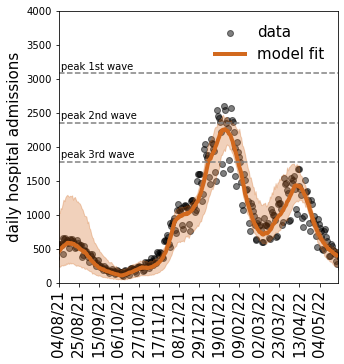

In [11]:
## fit - 7m delay

color_melanzana = '#495057'
melanzana_CI = '#9a8c98'

n_runs = 100

folder = './../scenarios/scenario_booster_delay_7m_adu_ritmo3/'
baseline = pd.read_csv('./{}/new_H_France_scenario_fit_runs{}_both_both_reduction0.0_start-week53_4weeks.csv'.format(folder,
                                                                                                n_runs))

baseline_week = aggregate_week(baseline)

#### daaaay

plt.figure(figsize=(5,5))

plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'], 
            color='black', alpha = 0.5, label = 'data')
#plt.plot(H_adm_cut.index, H_adm_cut['hosp_pred'].rolling(window=7).mean(), 
#         color='black', label='data (rolling mean)', linewidth = 4)

plt.plot(baseline['median'], color='chocolate', label='model fit', linewidth = 4)
plt.fill_between(baseline.index, baseline['p1'].values, 
                                 baseline['p2'].values, color='chocolate', alpha=0.3)


#folder = './../../17_adol70%-50%Wuhan_100%-100%Alpha_IHR-omicron-0.2_max(1-(1-VE)0.5,NE)_reinfect-Omi-Omi_R-delta-waned/8_delta-vs-BA1-BA2_uptow20/cluster_simulations/scenario_booster_delay_7m_adu_ritmo3'
#baseline = pd.read_csv('./{}/new_H_France_scenario_fit_runs{}_both_both_reduction0.0_start-week53_4weeks.csv'.format(folder,
     #                                                                                           n_runs))
#baseline_week = aggregate_week(baseline)
#plt.plot(baseline['median'], color='green', label='model fit', linewidth = 4)
#plt.fill_between(baseline.index, baseline['p1'].values, 
#                                 baseline['p2'].values, color='green', alpha=0.3)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           frameon = False, loc='upper right', fontsize=15)
plt.ylabel('daily hospital admissions', fontsize=15)

plt.xlim([12,len(baseline)])
plt.yticks(np.arange(0,4600,500))

plt.ylim([0, 4000])

plt.axhline(peak_daily['wave1'], linestyle='--', color='grey')
plt.axhline(peak_daily['wave2'], linestyle='--', color='grey')
plt.axhline(peak_daily['wave3'], linestyle='--', color='grey')

plt.text(12.1, peak_daily['wave1']+50, 'peak 1st wave')
plt.text(12.1, peak_daily['wave2']+50, 'peak 2nd wave')
plt.text(12.1, peak_daily['wave3']+50, 'peak 3rd wave')

move = 10
end = len(baseline)
step = 21
dates=pd.to_datetime(baseline['time']).apply(lambda x:x.strftime("%d/%m/%y"))
plt.xticks(np.arange(move,end,step), labels = dates[move: end : step],
           rotation=90, fontsize=15) 

plt.savefig('{}/0_trajectory_fit.png'.format(path_figure), bbox_inches='tight', dpi=300)
plt.show()

# SKIP to section of interest

In [12]:
main_folder = './../scenarios/'

# trajectories with 0% reduction

## fig 2 d-f

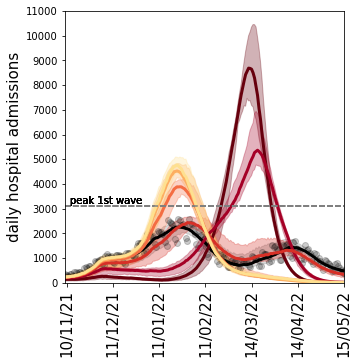

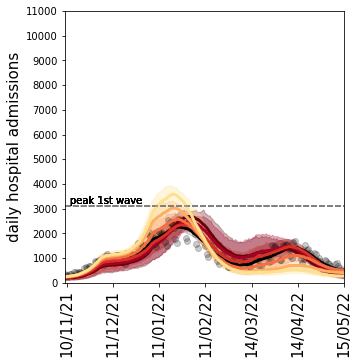

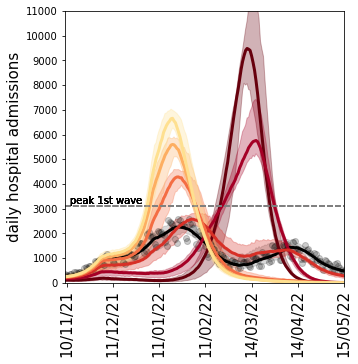

In [13]:
for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84']:

        for classi in ['adu', 'sen', 'adu_sen']: 
            
            plt.subplots(figsize=(5,5))
            plt.plot(baseline.index.to_numpy(), baseline['median'].to_numpy(), color='black', label='fit', linewidth = 3)
            plt.fill_between(baseline.index, baseline['p1'].values, baseline['p2'].values, color='grey', alpha=0.3)

            for delay in [4,5,6,7,8,9]:

                sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)
                #tag_scenario = 'delay_{}m_{}'.format(delay, classi)
                tag_scenario = 'delay_{}m_{}'.format(delay, 'adu')
                i = 0
                n_runs = 100

                for reduction in [0.]: 
                    reduction = np.around(reduction,2)
                    tag = 'reduction{}_start-week53_4weeks'.format(reduction)
                    
                    my_file = main_folder+sub_folder+'/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                n_runs, tag)
                    
                    if Path(my_file).exists():

                        df = pd.read_csv(my_file)

                        plt.plot(df['median'], label=etichetta_ritardo[ritmo][delay]+ ' ({})'.format(classi), 
                                linewidth = 3, color=cols_dict[tag_scenario])
                        plt.fill_between(df.index, df['p1'], df['p2'], color=cols_dict[tag_scenario],
                                                        alpha = 0.3)
                        
                        #plt.axhline(y=peak["wave1"]/7, color='black', linestyle="--")
                        plt.axhline(peak_daily['wave1'], linestyle='--', color='grey')
                        plt.text(110.1, peak_daily['wave1']+100, 'peak 1st wave')
                        
                    else: 
                        print('missing')
                        
                    i+=1

            #plt.legend(frameon = False, loc='upper left', bbox_to_anchor=(1,1), fontsize=12)
            plt.ylabel('daily hospital admissions', fontsize=15)
            plt.xlim([8,len(df)])
            plt.yticks(np.arange(0,12000,1000))
            plt.ylim([0, 11000])
            #plt.title(ritmo + ', reduction 0%'+'\n'+buffer)
            move = 15
            end = len(df)
            step = 31
            dates=pd.to_datetime(df['time']).apply(lambda x:x.strftime("%d/%m/%y"))
            plt.xticks(np.arange(move,end,step), labels = dates[move: end : step],
                       rotation=90, fontsize=15) 
            plt.xlim([baseline[baseline['time']=='2021-11-09'].index[0], len(baseline)-8])
            plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'], 
                        color='black', alpha = 0.2, label = 'data')
            plt.savefig('{}/2a_traj_{}_{}{}_red_{}_nruns{}.png'.format(path_figure,
                                                                      ritmo,classi,buffer,reduction,n_runs),
                                                                        dpi = 200, bbox_inches = 'tight')
            plt.show()

## comparison limited vs full coverage

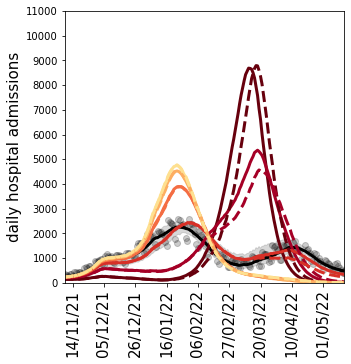

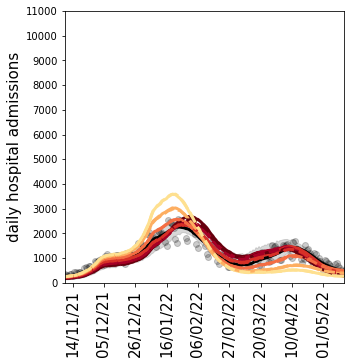

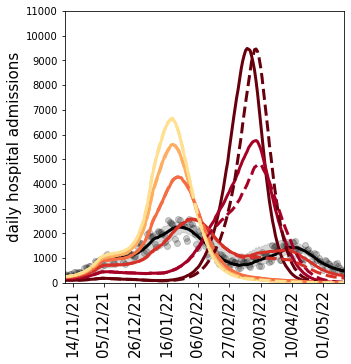

In [14]:
### comparison

H_adm_cut = H_adm[H_adm['date']>='2021-07-25'].reset_index(drop=True)

for classi in ['adu', 'sen', 'adu_sen']: 
    
    plt.subplots(figsize=(5,5))
    
    plt.plot(baseline.index, baseline['median'], color='black', label='fit', linewidth = 3)
    plt.fill_between(baseline.index, baseline['p1'].values, 
                                     baseline['p2'].values, color='grey', alpha=0.3)
    
    linestyles = ['-', '--', ':', '-.']
    
    h=-1
            
    for ritmo in ['ritmo2_start20210901']:
    
        for buffer in ['_buffer30days_cov70-84', '_buffer30days']:
            
            h+=1

            for delay in [4,5,6,7,8,9]:

                sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                #tag_scenario = 'delay_{}m_{}'.format(delay, classi)
                tag_scenario = 'delay_{}m_{}'.format(delay, 'adu')
                

                i = 0

                n_runs = 100

                for reduction in [0.]: 

                    reduction = np.around(reduction,2)

                    tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                    df = pd.read_csv(main_folder+sub_folder+'/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                n_runs, tag))
                    plt.plot(df['median'], label=etichetta_ritardo[ritmo][delay]+ ' ({} {})'.format(classi,buffer[13:]), 
                            linewidth = 3, color=cols_dict[tag_scenario], linestyle=linestyles[h])

                    i+=1

    plt.ylabel('daily hospital admissions', fontsize=15)

    plt.xlim([8,len(df)])
    plt.yticks(np.arange(0,12000,1000))
    plt.ylim([0, 11000])

    #plt.title(ritmo + ', reduction 0%'+'\n'+buffer)

    move = 7
    end = len(df)
    step = 21
    dates=pd.to_datetime(df['time']).apply(lambda x:x.strftime("%d/%m/%y"))
    plt.xticks(np.arange(move,end,step), labels = dates[move: end : step],
               rotation=90, fontsize=15) 

    plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'], 
                color='black', alpha = 0.2, label = 'data')
    plt.xlim([baseline[baseline['time']=='2021-11-09'].index[0], len(baseline)-8])
    
    plt.savefig('{}/2b_traj_{}_red_{}_nruns{}_limited-vs-full.png'.format(path_figure,classi,reduction,n_runs),
                                                                dpi = 200, bbox_inches = 'tight')

    plt.show()

## comparison august vs september

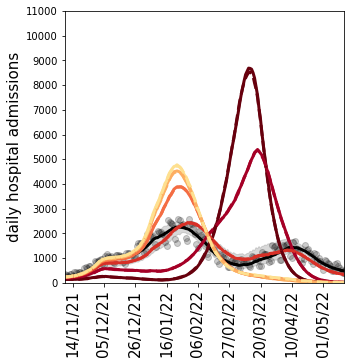

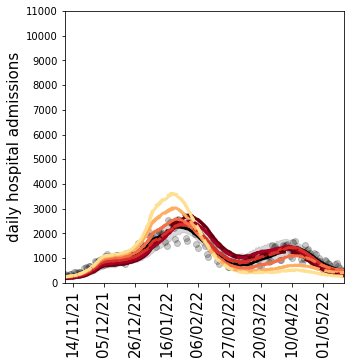

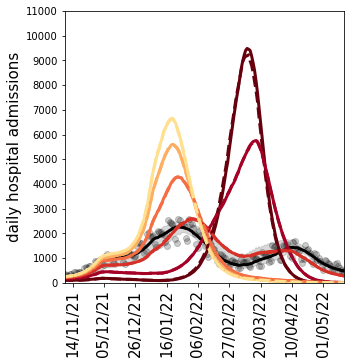

In [15]:
### comparison

H_adm_cut = H_adm[H_adm['date']>='2021-07-25'].reset_index(drop=True)



for classi in ['adu', 'sen', 'adu_sen']: 
    
    plt.subplots(figsize=(5,5))
    
    plt.plot(baseline.index, baseline['median'], color='black', label='fit', linewidth = 3)
    plt.fill_between(baseline.index, baseline['p1'].values, 
                                     baseline['p2'].values, color='grey', alpha=0.3)
    
    linestyles = ['-', '--', 
                  ':', '-.']
    
    h=-1
            
    for ritmo in ['ritmo2_start20210901', 'ritmo2_start20210801']:
    
        for buffer in ['_buffer30days_cov70-84']:
            
            h+=1

            for delay in [4,5,6,7,8,9]:

                sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                #tag_scenario = 'delay_{}m_{}'.format(delay, classi)
                tag_scenario = 'delay_{}m_{}'.format(delay, 'adu')
                

                i = 0

                n_runs = 100

                for reduction in [0.]: 

                    reduction = np.around(reduction,2)

                    tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                    df = pd.read_csv(main_folder+sub_folder+'/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                n_runs, tag))
                    plt.plot(df['median'], label=etichetta_ritardo[ritmo][delay]+ ' ({} {})'.format(classi,buffer[13:]), 
                            linewidth = 3, color=cols_dict[tag_scenario], linestyle=linestyles[h])

                    i+=1

    plt.ylabel('daily hospital admissions', fontsize=15)

    plt.xlim([8,len(df)])
    plt.yticks(np.arange(0,12000,1000))
    plt.ylim([0, 11000])

    #plt.title(ritmo + ', reduction 0%'+'\n'+buffer)

    move = 7
    end = len(df)
    step = 21
    dates=pd.to_datetime(df['time']).apply(lambda x:x.strftime("%d/%m/%y"))
    plt.xticks(np.arange(move,end,step), labels = dates[move: end : step],
               rotation=90, fontsize=15) 

    plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'], 
                color='black', alpha = 0.2, label = 'data')
    plt.xlim([baseline[baseline['time']=='2021-11-09'].index[0], len(baseline)-8])
    
    plt.savefig('{}/2b_traj_{}_red_{}_nruns{}_sept-vs-aug.png'.format(path_figure,classi,reduction,n_runs),
                                                                dpi = 200, bbox_inches = 'tight')

    plt.show()

# synthetic plots with 0% reduction

## peak vs peak week

### fig 2h

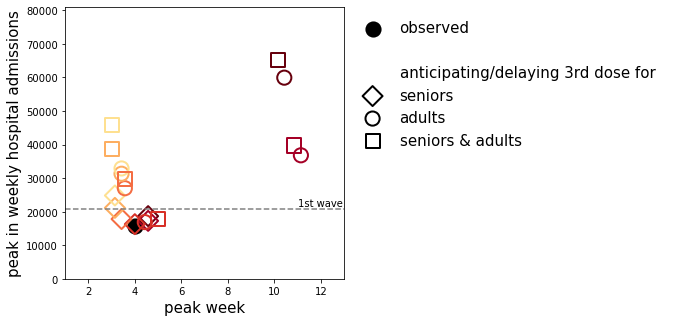

In [16]:


m_class = dict(zip(['sen', 'adu', 'adu_sen'],
                   ['D', 'o', 's']))
    
for buffer in ['_buffer30days_cov70-84']:

    for ritmo in ['ritmo2_start20210901']:
        
        plt.subplots(figsize=(5,5))
        
        size = 200

        df = H_adm_week.copy()
        ww = df.iloc[df['hosp_pred'].idxmax()]['abs_week']-53-52
        pp = df.iloc[df['hosp_pred'].idxmax()]['hosp_pred']
        plt.scatter(ww, pp, 
                    edgecolor='black', 
                    linewidth=2,
                    facecolor='black', 
                    marker = 'o', s = size, label = 'observed')

        df = baseline_week.copy()
        ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52
        pp = df.iloc[df['median'].idxmax()]['median']
        
        
        plt.scatter([], [], marker = 'o', color='white', label = ' ')
        plt.scatter([], [], marker = 'o', color='white', label = 'anticipating/delaying 3rd dose for ')
        
        
        
        plt.scatter([], [], edgecolor='black', linewidth=2,
                facecolor='None', marker = m_class['sen'], s = size, label='seniors')
        plt.scatter([], [], edgecolor='black', linewidth=2,
                facecolor='None', marker = m_class['adu'], s = size, label='adults')
        plt.scatter([], [], edgecolor='black', linewidth=2,
                facecolor='None', marker = m_class['adu_sen'], s = size, label='seniors & adults')
        
        plt.legend(fontsize=15, bbox_to_anchor=(1,1), frameon=False)
            
            
        for classi in ['sen', 'adu', 'adu_sen']: 

            for delay in [4,5,6,7,8,9]:

                sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)
                #tag_scenario = 'delay_{}m_{}'.format(delay, classi)
                tag_scenario = 'delay_{}m_{}'.format(delay, 'adu')
            
                n_runs = 100

                for reduction in [0.]: 
                    reduction = np.around(reduction,2)
                    tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                    
                    my_file = main_folder+sub_folder+'/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                n_runs, tag)
                    
                    if Path(my_file).exists():
                        
                        df = pd.read_csv(my_file)
                        
                        df = aggregate_moving_week(df)
                        ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52
                        pp = df.iloc[df['median'].idxmax()]['median']

                        if 'cov70-84' in buffer:
                            face_col = 'None'
                            edge_col =  cols_dict[tag_scenario]
                        else:
                            face_col=cols_dict[tag_scenario]
                            edge_col = 'white'

                        plt.scatter(ww, pp, 
                                    edgecolor=edge_col, linewidth=2,
                                    facecolor=face_col, marker = m_class[classi], 
                                    s = size, label=etichetta_ritardo[ritmo][delay]+' ({})'.format(classi))
                    
                    else: 
                        print('missing')
                    
                    
                    
        plt.xlabel('peak week', fontsize=15)
        plt.ylabel('peak in weekly hospital admissions', fontsize=15)
        plt.axhline(peak['wave1'], linestyle='--', color='grey')
        #plt.axhline(peak['wave2'], linestyle='--', color='grey')
        #plt.axhline(peak['wave3'], linestyle='--', color='grey')
        plt.text(11., peak['wave1']+800, '1st wave')
        #plt.text(1.1, peak['wave2']-1500, '2nd wave')
        #plt.title(ritmo + buffer)
        plt.xlim([1,13])
        plt.ylim([0,81000])

        plt.savefig('{}/3_peak-vs-peaktime_{}_{}_red{}_nruns{}_moving.png'.format(path_figure,ritmo,buffer, 
                                                                                         reduction,n_runs),
                                                                            dpi = 200, bbox_inches = 'tight')
        plt.show()

### fig 2h adults only

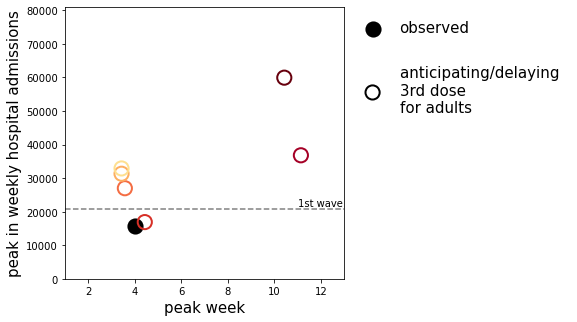

In [17]:


m_class = dict(zip(['sen', 'adu', 'adu_sen'],
                   ['D', 'o', 's']))
    
for buffer in ['_buffer30days_cov70-84']:

    for ritmo in ['ritmo2_start20210901']:
        
        plt.subplots(figsize=(5,5))
        
        size = 200

        df = H_adm_week.copy()
        ww = df.iloc[df['hosp_pred'].idxmax()]['abs_week']-53-52
        pp = df.iloc[df['hosp_pred'].idxmax()]['hosp_pred']
        plt.scatter(ww, pp, 
                    edgecolor='black', 
                    linewidth=2,
                    facecolor='black', 
                    marker = 'o', s = size, label = 'observed')

        df = baseline_week.copy()
        ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52
        pp = df.iloc[df['median'].idxmax()]['median']
        
        
        plt.scatter([], [], marker = 'o', color='white', label = ' ')
        #plt.scatter([], [], marker = 'o', color='white', label = 'anticipating/delaying 3rd dose for ')
        
        
        
        #plt.scatter([], [], edgecolor='black', linewidth=2,
        #        facecolor='None', marker = m_class['sen'], s = size, label='seniors')
        plt.scatter([], [], edgecolor='black', linewidth=2,
                facecolor='None', marker = m_class['adu'], s = size, label='anticipating/delaying \n3rd dose \nfor adults')
        #plt.scatter([], [], edgecolor='black', linewidth=2,
        #        facecolor='None', marker = m_class['adu_sen'], s = size, label='seniors & adults')
        
        plt.legend(fontsize=15, bbox_to_anchor=(1,1), frameon=False)
            
            
        for classi in ['adu']: 

            for delay in [4,5,6,7,8,9]:

                sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)
                #tag_scenario = 'delay_{}m_{}'.format(delay, classi)
                tag_scenario = 'delay_{}m_{}'.format(delay, 'adu')
            
                n_runs = 100

                for reduction in [0.]: 
                    reduction = np.around(reduction,2)
                    tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                    
                    my_file = main_folder+sub_folder+'/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                n_runs, tag)
                    
                    if Path(my_file).exists():
                        
                        df = pd.read_csv(my_file)
                        
                        df = aggregate_moving_week(df)
                        ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52
                        pp = df.iloc[df['median'].idxmax()]['median']

                        if 'cov70-84' in buffer:
                            face_col = 'None'
                            edge_col =  cols_dict[tag_scenario]
                        else:
                            face_col=cols_dict[tag_scenario]
                            edge_col = 'white'

                        plt.scatter(ww, pp, 
                                    edgecolor=edge_col, linewidth=2,
                                    facecolor=face_col, marker = m_class[classi], 
                                    s = size, label=etichetta_ritardo[ritmo][delay]+' ({})'.format(classi))
                    
                    else: 
                        print('missing')
                    
                    
                    
        plt.xlabel('peak week', fontsize=15)
        plt.ylabel('peak in weekly hospital admissions', fontsize=15)
        plt.axhline(peak['wave1'], linestyle='--', color='grey')
        #plt.axhline(peak['wave2'], linestyle='--', color='grey')
        #plt.axhline(peak['wave3'], linestyle='--', color='grey')
        plt.text(11., peak['wave1']+800, '1st wave')
        #plt.text(1.1, peak['wave2']-1500, '2nd wave')
        #plt.title(ritmo + buffer)
        plt.xlim([1,13])
        plt.ylim([0,81000])

        plt.savefig('{}/3_peak-vs-peaktime_{}_{}_red{}_nruns{}_moving_adults_only.png'.format(path_figure,ritmo,buffer, 
                                                                                         reduction,n_runs),
                                                                            dpi = 200, bbox_inches = 'tight')
        plt.show()

## peak vs vax scenario

### fig 2g with error bars

sen 4 18680.0
sen 5 17263.5
sen 6 16283.5
sen 7 17810.5
sen 8 21139.5
sen 9 24830.0
adu 4 59940.5
adu 5 36807.0
adu 6 16901.0
adu 7 26993.5
adu 8 31313.5
adu 9 32888.0
adu_sen 4 65321.5
adu_sen 5 39707.0
adu_sen 6 17913.5
adu_sen 7 29689.0
adu_sen 8 38731.0
adu_sen 9 45877.0


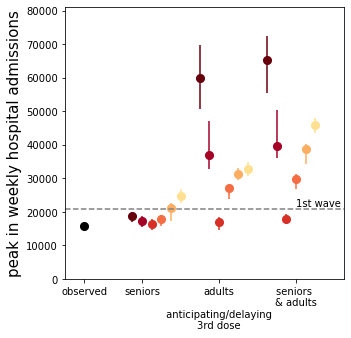

In [18]:


m_class = dict(zip(['sen', 'adu', 'adu_sen'],
                   ['o', 'o', 'o']))
    
for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84']:
        
        plt.subplots(figsize=(5,5))

        size = 50

        df = H_adm_week.copy()

        ww = df.iloc[df['hosp_pred'].idxmax()]['abs_week']-53-52

        pp = df.iloc[df['hosp_pred'].idxmax()]['hosp_pred']

        plt.scatter(-1, pp, 
                    edgecolor='black', 
                    linewidth=2,
                    facecolor='black', 
                    marker = 'o', s = size, label = 'data')

        i = 0.5

        for classi in ['sen','adu','adu_sen']: 

            i+=0.5

            for delay in [4,5,6,7,8,9]:

                i+=0.5

                sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                #tag_scenario = 'delay_{}m_{}'.format(delay, classi)
                tag_scenario = 'delay_{}m_{}'.format(delay, 'adu')
                

                n_runs = 100

                build_ww = []
                build_pp = []

                if delay in [4,5,6,7,8,9]:

                    for reduction in [0.]: 

                        reduction = np.around(reduction,2)

                        tag = 'reduction{}_start-week53_4weeks'.format(reduction)
                        
                        my_file = main_folder+sub_folder+'/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                    n_runs, tag)

                        if Path(my_file).exists():

                            df = pd.read_csv(my_file)

                            df = aggregate_moving_week(df)
                            
                            #df = aggregate_week(df)
                            
                            ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52
                            pp = df.iloc[df['median'].idxmax()]['median']
                            
                            pp_dw = df.iloc[df['median'].idxmax()]['p1']
                            pp_up = df.iloc[df['median'].idxmax()]['p2']

                            if 'cov70-84' in buffer:
                                face_col = 'None'
                                edge_col =  cols_dict[tag_scenario]
                            else:
                                face_col=cols_dict[tag_scenario]
                                edge_col = 'white'

                            plt.scatter(i, pp, 
                                        edgecolor=edge_col, 
                                        linewidth=2,
                                        facecolor=edge_col, 
                                        marker = m_class[classi], 
                                        #s = size*(1.-3*reduction), 
                                        s = 50,
                                        label=etichetta_ritardo[ritmo][delay]+\
                                        ' ({})'.format(classi))
                            
                            plt.vlines(i, pp_dw, pp_up, color=edge_col)
                            print(classi,delay,pp)
                            
                        else: 
                            print('missing')


        plt.ylabel('peak in weekly hospital admissions', fontsize=15)

        plt.axhline(peak['wave1'], linestyle='--', color='grey')
        #plt.axhline(peak['wave2'], linestyle='--', color='grey')
        #plt.axhline(peak['wave3'], linestyle='--', color='grey')

        plt.text(10, peak['wave1']+800, '1st wave')

        plt.xlim([-2,12.5])
        plt.ylim([0,81000])

        plt.xticks([-1, 2, 6, 10], labels= ['observed', 'seniors', 
                                            'adults\n\n anticipating/delaying \n3rd dose', 
                                            'seniors \n& adults\n'])

        plt.savefig('{}/4_peak-vs-type_{}_{}_red{}_nruns{}_moving_CI.png'.format(path_figure,ritmo,buffer,
                                                                                           reduction,n_runs),
                                                                                    dpi = 200, bbox_inches = 'tight')

        plt.show()

# trajectories w/ additional SD

## all trajectories

## selected trajectories for fig 3 a-b

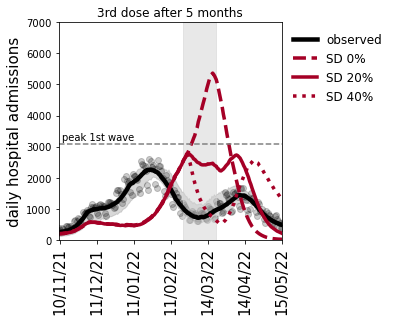

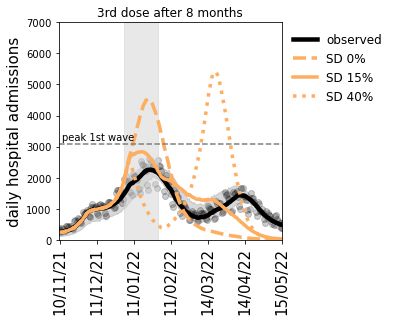

In [19]:

    
for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84']:
        
        for delay in [5,8]:
            
            for classi in ['adu']: 
                
                if delay in [4,5]:
                    weeks = [60]
                else:
                    weeks = [53]
                
                for starting_week_SD in weeks:

                    plt.subplots(figsize=(4,4))
                    
                    """if delay == 6:
                        for x in np.arange(0., 0.85, 0.05):
                            plt.plot([], [], 
                                color='black', alpha = 1.-x, label = '{}%'.format(int(x*100)))

                    plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1),
                              fontsize=20)"""
                    
                    plt.plot(baseline['median'], color='black', label='observed', linewidth = 4.5)
                    plt.fill_between(baseline.index, baseline['p1'].values, 
                                                     baseline['p2'].values, color='grey', alpha=0.3)


                    sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                    tag_scenario = 'delay_{}m_{}'.format(delay, classi)

                    i = 0

                    n_runs = 100

                    if delay in [4,5,6,7,9]:
                        #list_reduction = np.arange(0., 0.6, 0.15)
                        list_reduction = [0., 0.2, 0.4]

                        
                    elif delay == 8:
                        #list_reduction = np.arange(0., 0.6, 0.15)
                        list_reduction = [0., 0.15, 0.4]
                        
                    else:
                        sys.exit()

                    alpha = 1.
                    
                    kk = 0
                    
                    for reduction in list_reduction:

                        reduction = np.around(reduction,2)

                        tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)

                        if reduction == 0.:
                            tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                        my_file = main_folder+sub_folder+'/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                    n_runs, tag)

                        if Path(my_file).exists():

                            df = pd.read_csv(my_file)

                            if reduction in [0.]:
                                ll = '--'
                            elif reduction in [0.4]:
                                ll = ':'
                            else:
                                ll = '-'

                            plt.plot(df['median'], label= 'SD {}%'.format(int(reduction*100)), 
                                        linewidth = 3.5 + kk, color=cols_dict[tag_scenario], linestyle = ll, alpha = 1.0)

                        else: 
                            print('missing')

                        alpha-=0.15
                        #kk -=1
                        
                    plt.legend(frameon = False, loc='upper left', 
                               fontsize=12, bbox_to_anchor = (1,1))
                    
                    
                    starting_date = datetime.date.fromisocalendar(2022, starting_week_SD-52, 1).strftime('%Y-%m-%d')

                    """ 
                    plt.axvline(x = baseline[baseline['time']==starting_date].index[0], 
                                color='black', linestyle = '--')
                    
                    if delay in [4,5]:
                        plt.text(baseline[baseline['time']==starting_date].index[0]-14, 4450,
                            'end of school holidays', rotation = 90)
                    elif delay in [6,7,8,9]:
                        plt.text(baseline[baseline['time']==starting_date].index[0]-14, 4500,
                            'end of xmas holidays', rotation = 90)                        
                    else:
                        sys.exit()
                    """
                        
                    plt.axvspan(xmin = baseline[baseline['time']==starting_date].index[0],
                                xmax = baseline[baseline['time']==starting_date].index[0]+7*4, 
                                color='lightgrey', alpha = 0.5)

                    plt.axhline(peak_daily['wave1'], linestyle='--', color='grey')
                    plt.text(110.1, peak_daily['wave1']+100, 'peak 1st wave')

                    plt.ylabel('daily hospital admissions', fontsize=15)

                    plt.xlim([8,len(baseline)])
                    plt.yticks(np.arange(0,10000,1000))
                    plt.ylim([0, 7000])

                    plt.title('3rd dose after {} months'.format(delay))

                    move = 15
                    end = len(df)
                    step = 31
                    dates=pd.to_datetime(df['time']).apply(lambda x:x.strftime("%d/%m/%y"))
                    plt.xticks(np.arange(move,end,step), labels = dates[move: end : step],
                               rotation=90, fontsize=15) 
                    plt.xlim([baseline[baseline['time']=='2021-11-09'].index[0], len(baseline)-8])

                    plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'], 
                                color='black', alpha = 0.2, label = 'data')
                    

                    plt.savefig('{}/5b_traj_{}_{}{}_{}_{}_nruns{}_{}m_example.png'.format(path_figure,ritmo,classi,buffer,'application-SD-w',
                                                                                               starting_week_SD-52,
                                                                                               n_runs,delay),
                                                                                 dpi = 200, bbox_inches = 'tight')

                    plt.show()

# synthetic plot X% social distancing

## fig 2c (peak vs peak week)

In [20]:
(26774.5 - peak['wave1'])/peak['wave1']

0.2915199459746274

adu 4 59940.5
adu 4 52795.5
adu 4 45717.0
adu 4 39531.5
adu 4 33575.5
adu 4 29812.5
adu 4 28438.5
adu 4 26748.5
adu 4 26774.5
adu 5 36807.0
adu 5 31934.0
adu 5 26266.5
adu 5 21377.5
adu 5 19012.5
adu 5 18678.5
adu 5 18436.5
adu 5 18500.0
adu 5 18389.0
adu 6 16901.0
adu 6 13373.5
adu 6 18263.0
adu 6 23783.0
adu 6 29396.5
adu 6 35336.5
adu 6 41779.5
adu 6 47418.5
adu 6 52907.5
adu 7 26993.5
adu 7 22823.0
adu 7 19069.0
adu 7 16056.0
adu 7 15278.0
adu 7 16186.5
adu 7 21486.5
adu 7 26673.5
adu 7 31544.0
adu 8 31313.5
adu 8 26829.5
adu 8 22818.5
adu 8 19738.5
adu 8 18669.0
adu 8 18726.5
adu 8 24689.5
adu 8 30773.5
adu 8 37144.5
adu 9 32888.0
adu 9 28428.5
adu 9 24326.5
adu 9 21006.0
adu 9 19915.0
adu 9 21766.0
adu 9 28691.0
adu 9 36482.0
adu 9 44036.5


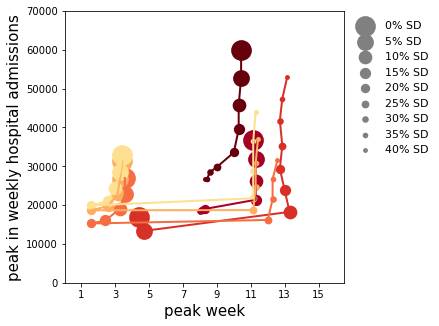

In [21]:
              
    
for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84']:

        for classi in ['adu']: 
            
            i = 1.0
    
            plt.subplots(figsize=(5,5))

            size = 350
            
            kk = 0
            
            for reduction in np.arange(0.0, 0.45, 0.05): 

                current_size = size/(1.6**kk)

                plt.scatter([], [], 
                            edgecolor='grey', 
                            linewidth=2,
                            facecolor='grey', 
                            marker = mm[ritmo], s = current_size, label='{}% SD'.format(int(reduction*100)))
                kk+=1

            plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1),
                      fontsize=11)

            df = H_adm_week.copy()

            ww = df.iloc[df['hosp_pred'].idxmax()]['abs_week']-53-52

            pp = df.iloc[df['hosp_pred'].idxmax()]['hosp_pred']

            """plt.scatter(ww, pp, 
                        edgecolor='black', 
                        linewidth=2,
                        facecolor='black', 
                        marker = 'o', s = size, label = 'data')"""

            for delay in [4,5,6,7,8,9]:
                
                if delay in [4,5]:
                    weeks = [60]
                else:
                    weeks = [53]
                    
                
                for starting_week_SD in weeks:
                    
                    #plt.vlines(starting_week_SD-52,0,8000, 
                    #           linestyle = '-', color=cols_dict[tag_scenario], 
                    #           label = 'implementing SD')
                
                    i+=0.5

                    sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                    tag_scenario = 'delay_{}m_{}'.format(delay, classi)

                    n_runs = 100

                    build_ww = []
                    build_pp = []

                    if delay in [4,5,6,7,8,9]:
                        list_reduction = np.arange(0., 0.45, 0.05)
                    elif delay == 6:
                        list_reduction = np.arange(0., 0.45, 0.05)
                    else:
                        sys.exit()
                        
                    kk = 0

                    for reduction in list_reduction: 

                        reduction = np.around(reduction,2)

                        if delay in [4,5]:
                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)
                        else:
                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)

                        if reduction == 0.:
                            tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                        df = pd.read_csv(main_folder+sub_folder+\
                                         '/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                    n_runs, tag))
                        #df = aggregate_week(df)
                        df = aggregate_moving_week(df)

                        ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52

                        pp = df.iloc[df['median'].idxmax()]['median']

                        build_ww.append(ww)
                        build_pp.append(pp)

                        current_size = size/(1.6**kk)
                        kk+=1

                        plt.scatter(ww, pp, 
                                edgecolor=cols_dict[tag_scenario], 
                                linewidth=2,
                                facecolor=cols_dict[tag_scenario], 
                                marker = mm[ritmo], s = current_size, label=etichetta_ritardo[ritmo][delay]+\
                                ' ({})'.format(classi))
                        print(classi, delay, pp)

                    plt.plot(build_ww, build_pp, '-',
                                    linewidth=2,
                                   color=cols_dict[tag_scenario])
                        


            plt.xlabel('peak week', fontsize=15)
            plt.ylabel('peak in weekly hospital admissions', fontsize=15)

            #plt.axhline(peak['wave1'], linestyle='--', color='grey')
            #plt.axhline(peak['wave2'], linestyle='--', color='grey')
            #plt.axhline(peak['wave3'], linestyle='--', color='grey')
            #plt.axhline(peak['wave5'], linestyle='--', color='grey')

            #plt.text(22, peak['wave1']-1500, '1st wave')
            #plt.text(0.8, peak['wave2']-1500, '2nd wave')
            #plt.text(0.8, peak['wave3']-1500, '3rd wave')
            #plt.text(22, peak['wave5']-1500, 'Omicron wave')

            plt.ylim([0,70000])

            plt.xticks(np.arange(1,17,2))
            plt.xlim([0.05,16.5])

            plt.savefig('{}/7a_peak-vs-peaktime_{}_{}{}_{}_nruns{}_moving.png'.format(path_figure,ritmo,classi,buffer, 
                                                                            'application-SD', n_runs),
                                                                            dpi = 200, bbox_inches = 'tight')
            plt.show()

adu 5 36807.0
adu 5 31934.0
adu 5 26266.5
adu 5 21377.5
adu 5 19012.5
adu 5 18678.5
adu 5 18436.5
adu 5 18500.0
adu 5 18389.0
adu 8 31313.5
adu 8 26829.5
adu 8 22818.5
adu 8 19738.5
adu 8 18669.0
adu 8 18726.5
adu 8 24689.5
adu 8 30773.5
adu 8 37144.5


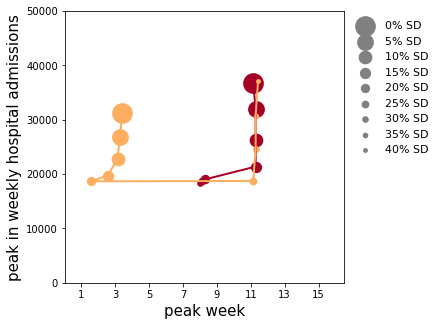

In [22]:

for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84']:

        for classi in ['adu']: 
            
            i = 1.0
    
            plt.subplots(figsize=(5,5))

            size = 350
            
            kk = 0
            
            for reduction in np.arange(0.0, 0.45, 0.05): 

                current_size = size/(1.6**kk)

                plt.scatter([], [], 
                            edgecolor='grey', 
                            linewidth=2,
                            facecolor='grey', 
                            marker = mm[ritmo], s = current_size, label='{}% SD'.format(int(reduction*100)))
                kk+=1

            plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1),
                      fontsize=11)

            df = H_adm_week.copy()

            ww = df.iloc[df['hosp_pred'].idxmax()]['abs_week']-53-52

            pp = df.iloc[df['hosp_pred'].idxmax()]['hosp_pred']

            """plt.scatter(ww, pp, 
                        edgecolor='black', 
                        linewidth=2,
                        facecolor='black', 
                        marker = 'o', s = size, label = 'data')"""

            for delay in [5,8]:
                
                if delay in [4,5]:
                    weeks = [60]
                else:
                    weeks = [53]
                    
                
                for starting_week_SD in weeks:
                    
                    #plt.vlines(starting_week_SD-52,0,8000, 
                    #           linestyle = '-', color=cols_dict[tag_scenario], 
                    #           label = 'implementing SD')
                
                    i+=0.5

                    sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                    tag_scenario = 'delay_{}m_{}'.format(delay, classi)

                    n_runs = 100

                    build_ww = []
                    build_pp = []

                    if delay in [4,5,6,7,8,9]:
                        list_reduction = np.arange(0., 0.45, 0.05)
                    elif delay == 6:
                        list_reduction = np.arange(0., 0.45, 0.05)
                    else:
                        sys.exit()
                        
                    kk = 0

                    for reduction in list_reduction: 

                        reduction = np.around(reduction,2)

                        if delay in [4,5]:
                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)
                        else:
                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)

                        if reduction == 0.:
                            tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                        df = pd.read_csv(main_folder+sub_folder+\
                                         '/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                    n_runs, tag))
                        #df = aggregate_week(df)
                        df = aggregate_moving_week(df)

                        ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52

                        pp = df.iloc[df['median'].idxmax()]['median']

                        build_ww.append(ww)
                        build_pp.append(pp)

                        current_size = size/(1.6**kk)
                        kk+=1

                        plt.scatter(ww, pp, 
                                edgecolor=cols_dict[tag_scenario], 
                                linewidth=2,
                                facecolor=cols_dict[tag_scenario], 
                                marker = mm[ritmo], s = current_size, label=etichetta_ritardo[ritmo][delay]+\
                                ' ({})'.format(classi))
                        
                        print(classi, delay, pp)

                    plt.plot(build_ww, build_pp, '-',
                                    linewidth=2,
                                   color=cols_dict[tag_scenario])


            plt.xlabel('peak week', fontsize=15)
            plt.ylabel('peak in weekly hospital admissions', fontsize=15)

            #plt.axhline(peak['wave1'], linestyle='--', color='grey')
            #plt.axhline(peak['wave2'], linestyle='--', color='grey')
            #plt.axhline(peak['wave3'], linestyle='--', color='grey')
            #plt.axhline(peak['wave5'], linestyle='--', color='grey')

            #plt.text(22, peak['wave1']-1500, '1st wave')
            #plt.text(0.8, peak['wave2']-1500, '2nd wave')
            #plt.text(0.8, peak['wave3']-1500, '3rd wave')
            #plt.text(22, peak['wave5']-1500, 'Omicron wave')

            plt.ylim([0,50000])

            plt.xticks(np.arange(1,17,2))
            plt.xlim([0.05,16.5])

            plt.savefig('{}/7b_peak-vs-peaktime_{}_{}{}_{}_nruns{}_moving_selected.png'.format(path_figure, ritmo,classi,buffer, 
                                                                            'application-SD', n_runs),
                                                                            dpi = 200, bbox_inches = 'tight')

            plt.show()

# CHOOSE THRESHOLD for sufficient SD

In [23]:
threshold = peak['wave1']

In [24]:
peak['wave1']

20731

## peak vs SD

### fig 2d, all curves

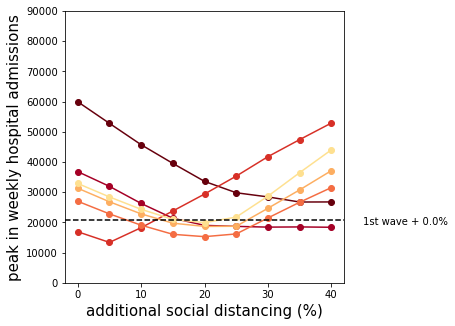

In [25]:
              
    
for ritmo in ['ritmo2_start20210901']:
    #for buffer in ['_buffer30days', '_buffer30days_cov70-84']:
    for buffer in ['_buffer30days_cov70-84']:

        #for classi in ['adu', 'adu_sen']: 
        for classi in ['adu']: 
            
            i = 1.0
    
            plt.subplots(figsize=(5,5))

            size = 50

            for delay in [4,5,6,7,8,9]:
                
                if delay in [4,5]:
                    weeks = [60]
                else:
                    weeks = [53]
                
                for starting_week_SD in weeks:
                
                    i+=0.5

                    sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                    tag_scenario = 'delay_{}m_{}'.format(delay, classi)

                    n_runs = 100

                    build_ww = []
                    build_pp = []

                    if delay in [4,5,7,8,9]:
                        list_reduction = np.arange(0., 0.45, 0.05)
                    elif delay == 6:
                        list_reduction = np.arange(0., 0.45, 0.05)
                    else:
                        sys.exit()

                    for reduction in list_reduction: 

                        reduction = np.around(reduction,2)

                        if delay in [4,5]:
                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)
                        else:
                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)

                        if reduction == 0.:
                            tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                        df = pd.read_csv(main_folder+sub_folder+\
                                         '/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                    n_runs, tag))
                        df = aggregate_moving_week(df)

                        ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52

                        pp = df.iloc[df['median'].idxmax()]['median']

                        build_ww.append(ww)
                        build_pp.append(pp)

                        if reduction == 0.:
                            current_size = size
                        else:
                            current_size = size*(1.-1*reduction)
                            #current_size = 0
                        
                    alpha = 1.0
                    line = '-o'                   
                    plt.plot(list_reduction, build_pp, line, color=cols_dict[tag_scenario], alpha = alpha)

            #plt.xlabel('week of peak', fontsize=15)
            plt.ylabel('peak in weekly hospital admissions', fontsize=15)

            #plt.axhline(peak['wave1'], linestyle='--', color='grey')
            #plt.axhline(peak['wave2'], linestyle='--', color='grey')
            #plt.axhline(peak['wave3'], linestyle='--', color='grey')
            #plt.axhline(peak['wave5'], linestyle='--', color='grey')
            plt.axhline(threshold, linestyle='--', color='black')
            

            #plt.text(0.45, peak['wave1']-1500, '1st wave')
            #plt.text(0.8, peak['wave2']-1500, '2nd wave')
            #plt.text(0.8, peak['wave3']-1500, '3rd wave')
            #plt.text(0.45, peak['wave5']-1500, 'Omicron wave')
            plt.text(0.45, threshold-1500, '1st wave + {}%'.format(100*threshold/peak['wave1']-100))

            

            plt.ylim([0,90000])

            plt.xticks(np.arange(0., 0.45, 0.1), labels = [int(a) for a in np.arange(0., 0.45, 0.1)*100])

            plt.xlabel('additional social distancing (%)', fontsize=15)

            plt.savefig('{}/6a_peak-vs-SD_{}_{}{}_{}_nruns{}_moving_threshold{}.png'.format(path_figure,ritmo,classi,buffer, 
                                                                        'application-SD', n_runs, int(threshold)),
                                                                        dpi = 200, bbox_inches = 'tight')
            plt.show()

## compute sufficient and most effective SD

In [26]:


dict_suf_red = {}
dict_suf_peak = {}
dict_opt_red = {}
dict_opt_peak = {}

for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84']:

        for classi in ['adu']: 

            for delay in [4,5,6,7,8,9]:
                
                if delay in [4,5]:
                    weeks = [60]
                else:
                    weeks = [53]
                
                for starting_week_SD in weeks:
                
                    sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                    tag_scenario = 'delay_{}m_{}'.format(delay, classi)
                    
                    tag_result = 'scenario_booster_delay_{}m_{}_{}{}_start-week{}'.format(delay, classi, ritmo, buffer, starting_week_SD)
                    
                    n_runs = 100

                    build_ww = []
                    build_pp = []

                    list_reduction = np.arange(0., 0.45, 0.05)
                        
                    found = False

                    for reduction in list_reduction: 

                        reduction = np.around(reduction,2)

                        if delay in [4,5]:
                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)
                        else:
                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)

                        if reduction == 0.:
                            tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                        df = pd.read_csv(main_folder+sub_folder+\
                                         '/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                        n_runs, tag))
                        #df = aggregate_week(df)
                        df = aggregate_moving_week(df)
                        
                        ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52

                        pp = df.iloc[df['median'].idxmax()]['median']

                        build_ww.append(ww)
                        build_pp.append(pp)
                            
                        if pp < threshold and not found:
                            sufficient_reduction = reduction
                            dict_suf_red[tag_result] = sufficient_reduction
                            dict_suf_peak[tag_result] = pp
                            
                            found = True
                            
                    if found == False:
                        dict_suf_red[tag_result] = None
                        dict_suf_peak[tag_result] = None
  
                    optimal_reduction = list_reduction[np.array(build_pp).argmin()]
        
                    dict_opt_red[tag_result] = optimal_reduction
                    dict_opt_peak[tag_result] = np.array(build_pp).min()           

In [27]:
peak

{'wave1': 20731, 'wave2': 16252, 'wave3': 12496, 'wave5': 15666}

### peak vs SD with circles for sufficient and most effective

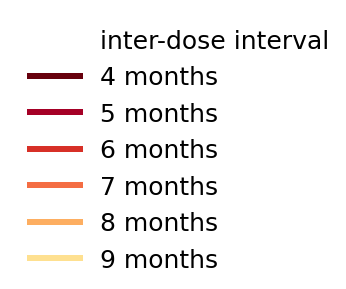

In [28]:


for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84']:

        for classi in ['adu']: 
    
            fig, axes = plt.subplots(figsize=(5,5))

            size = 200
            
            #plt.scatter([], [], color='white', label = ' ')
            plt.plot([], [], 'o-', color='white', label = 'inter-dose interval')
            
            for delay in [4,5,6,7,8,9]:
                plt.plot([], [], '-', color=cols_dict['delay_{}m_{}'.format(delay, 'adu')], 
                        label = '{} months'.format(delay), linewidth = 6)
                
            plt.legend(frameon=False, 
                       fontsize = 25, loc="upper left")
            
            axes.set_axis_off()

            #plt.savefig('{}/6c_legend.png'.format(path_figure),dpi = 200, bbox_inches = 'tight')
            
            plt.show()

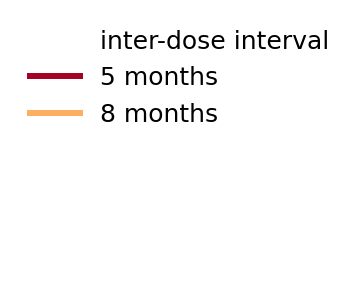

In [29]:


for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84']:

        for classi in ['adu']: 
    
            fig, axes = plt.subplots(figsize=(5,5))

            size = 200
            
            #plt.scatter([], [], color='white', label = ' ')
            plt.plot([], [], 'o-', color='white', label = 'inter-dose interval')
            
            for delay in [5,8]:
                plt.plot([], [], '-', color=cols_dict['delay_{}m_{}'.format(delay, 'adu')], 
                        label = '{} months'.format(delay), linewidth = 6)
                
            plt.legend(frameon=False, 
                       fontsize = 25, loc="upper left")
            
            axes.set_axis_off()

            #plt.savefig('{}/6c_legend_v2.png'.format(path_figure),dpi = 200, bbox_inches = 'tight')
            
            plt.show()

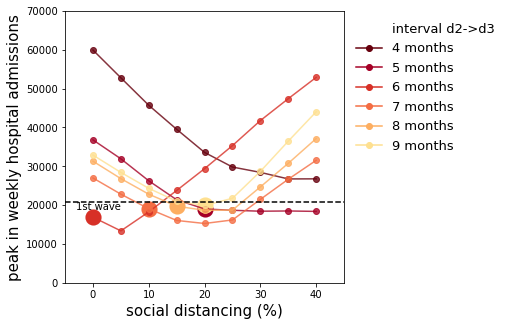

In [30]:


for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84']:

        for classi in ['adu']: 
    
            plt.subplots(figsize=(5,5))

            size = 200
            
            #plt.scatter([], [], color='white', label = ' ')
            plt.plot([], [], 'o-', color='white', label = 'interval d2->d3')
            
            for delay in [4,5,6,7,8,9]:
                plt.plot(-10, -10, 'o-', color=cols_dict['delay_{}m_{}'.format(delay, 'adu')], 
                        label = '{} months'.format(delay))
                
            plt.legend(frameon=False, 
                       fontsize = 13, bbox_to_anchor = (1,1))

            for delay in [4,5,6,7,8,9]:
                
                if delay in [4,5]:
                    weeks = [60]
                else:
                    weeks = [53]
                
                for starting_week_SD in weeks:
                
                    sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                    tag_scenario = 'delay_{}m_{}'.format(delay, classi)
                    
                    tag_result = 'scenario_booster_delay_{}m_{}_{}{}_start-week{}'.format(delay, classi, ritmo, buffer, starting_week_SD)
                    
                    n_runs = 100

                    build_ww = []
                    build_pp = []

                    list_reduction = np.arange(0., 0.45, 0.05)
                    
                    for reduction in list_reduction: 

                        reduction = np.around(reduction,2)

                        if delay in [4,5]:
                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)
                        else:
                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)

                        if reduction == 0.:
                            tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                        df = pd.read_csv(main_folder+sub_folder+\
                                         '/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                    n_runs, tag))
                        #df = aggregate_week(df)
                        df = aggregate_moving_week(df)
                        
                        ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52

                        pp = df.iloc[df['median'].idxmax()]['median']

                        build_ww.append(ww)
                        build_pp.append(pp)

                        if reduction == 0.:
                            current_size = size
                        else:
                            current_size = size*(1.-1*reduction)
                            current_size = size
                            
                    sufficient_reduction = dict_suf_red[tag_result] 
                    if sufficient_reduction != None:
                        plt.scatter(sufficient_reduction , dict_suf_peak[tag_result], 
                                    edgecolor=cols_dict[tag_scenario], 
                                    linewidth=2,
                                    facecolor=cols_dict[tag_scenario], 
                                    marker = mm[ritmo], s = current_size, label=etichetta_ritardo[ritmo][delay]+\
                                    ' ({})'.format(classi))
  
                    #optimal_reduction = list_reduction[np.array(build_pp).argmin()]
                    optimal_reduction = dict_opt_red[tag_result]
    
                    #plt.scatter(optimal_reduction, dict_opt_peak[tag_result], 
                    #            edgecolor=cols_dict[tag_scenario], 
                    #            linewidth=2,
                    #            facecolor='None', 
                    #            marker = mm[ritmo], s = current_size, label=etichetta_ritardo[ritmo][delay]+\
                    #            ' ({})'.format(classi))
        
                    plt.plot(list_reduction, build_pp, 'o-', color=cols_dict[tag_scenario], alpha = 0.8)

            #plt.xlabel('week of peak', fontsize=15)
            plt.ylabel('peak in weekly hospital admissions', fontsize=15)

            #plt.axhline(peak['wave1'], linestyle='--', color='grey')
            #plt.axhline(peak['wave5'], linestyle='--', color='grey')
            plt.axhline(threshold, linestyle='--', color='black')

            #plt.text(0.65, peak['wave1']-1500, '1st wave')
            #plt.text(0.65, peak['wave5']-1500, 'Omicron wave')
            #plt.text(0.65, threshold-1500, '1st + 20%')
            
            if threshold != peak['wave1']:
                plt.text(-0.03, threshold-2000, '1st wave + {}%'.format(100*threshold/peak['wave1']-100))
            else:
                plt.text(-0.03, threshold-2000, '1st wave')

            plt.ylim([0,70000])

            plt.xticks(np.arange(0., 0.85, 0.1), labels = [int(a) for a in np.arange(0., 0.85, 0.1)*100])
            plt.xlim([-0.05,0.45])
            
            plt.xlabel('social distancing (%)', fontsize=15)

            plt.savefig('{}/6c_peak-vs-SD_{}_{}{}_{}_nruns{}_shaded_moving_all_threshold{}_sufficient_only.png'.format(path_figure, 
                                                                        ritmo,classi,buffer, 
                                                                        'application-SD', n_runs, int(threshold)),
                                                                         dpi = 200, bbox_inches = 'tight')
            
            plt.show()

delay_5m_adu [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4 ] [36807.0, 31934.0, 26266.5, 21377.5, 19012.5, 18678.5, 18436.5, 18500.0, 18389.0]
delay_8m_adu [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4 ] [31313.5, 26829.5, 22818.5, 19738.5, 18669.0, 18726.5, 24689.5, 30773.5, 37144.5]


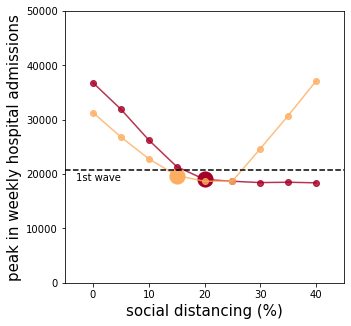

In [31]:


for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84']:

        for classi in ['adu']: 
    
            plt.subplots(figsize=(5,5))

            size = 200

            for delay in [5,8]:
                
                if delay in [4,5]:
                    weeks = [60]
                else:
                    weeks = [53]
                
                for starting_week_SD in weeks:
                
                    sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                    tag_scenario = 'delay_{}m_{}'.format(delay, classi)
                    
                    tag_result = 'scenario_booster_delay_{}m_{}_{}{}_start-week{}'.format(delay, classi, ritmo, buffer, starting_week_SD)
                    
                    n_runs = 100

                    build_ww = []
                    build_pp = []

                    list_reduction = np.arange(0., 0.45, 0.05)
                    
                    for reduction in list_reduction: 

                        reduction = np.around(reduction,2)

                        if delay in [4,5]:
                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)
                        else:
                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)

                        if reduction == 0.:
                            tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                        df = pd.read_csv(main_folder+sub_folder+\
                                         '/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                    n_runs, tag))
                        #df = aggregate_week(df)
                        df = aggregate_moving_week(df)
                        
                        ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52

                        pp = df.iloc[df['median'].idxmax()]['median']

                        build_ww.append(ww)
                        build_pp.append(pp)

                        if reduction == 0.:
                            current_size = size
                        else:
                            current_size = size*(1.-1*reduction)
                            current_size = size
                            
                    sufficient_reduction = dict_suf_red[tag_result] 
                    if sufficient_reduction != None:
                        plt.scatter(sufficient_reduction , dict_suf_peak[tag_result], 
                                    edgecolor=cols_dict[tag_scenario], 
                                    linewidth=2,
                                    facecolor=cols_dict[tag_scenario], 
                                    marker = mm[ritmo], s = current_size, label=etichetta_ritardo[ritmo][delay]+\
                                    ' ({})'.format(classi))
  
                    #optimal_reduction = list_reduction[np.array(build_pp).argmin()]
                    """"optimal_reduction = dict_opt_red[tag_result]
    
                    plt.scatter(optimal_reduction, dict_opt_peak[tag_result], 
                                edgecolor=cols_dict[tag_scenario], 
                                linewidth=2,
                                facecolor='None', 
                                marker = mm[ritmo], s = current_size, label=etichetta_ritardo[ritmo][delay]+\
                                ' ({})'.format(classi))
                    """
                    plt.plot(list_reduction, build_pp, 'o-', color=cols_dict[tag_scenario], alpha = 0.8)
                    print(tag_scenario, list_reduction, build_pp)
                    
            #plt.xlabel('week of peak', fontsize=15)
            plt.ylabel('peak in weekly hospital admissions', fontsize=15)

            #plt.axhline(peak['wave1'], linestyle='--', color='grey')
            #plt.axhline(peak['wave5'], linestyle='--', color='grey')
            
            if threshold != peak['wave1']:
                plt.text(-0.03, threshold-2000, '1st wave + {}%'.format(100*threshold/peak['wave1']-100))
            else:
                plt.text(-0.03, threshold-2000, '1st wave')
                
            plt.axhline(threshold, linestyle='--', color='black')

            #plt.text(0.65, peak['wave1']-1500, '1st wave')
            #plt.text(0.65, peak['wave5']-1500, 'Omicron wave')
            #plt.text(0.65, threshold-1500, '1st + 20%')
            

            plt.ylim([0,50000])

            plt.xticks(np.arange(0., 0.85, 0.1), labels = [int(a) for a in np.arange(0., 0.85, 0.1)*100])
            plt.xlim([-0.05,0.45])
            
            plt.xlabel('social distancing (%)', fontsize=15)

            plt.savefig('{}/6d_peak-vs-SD_{}_{}{}_{}_nruns{}_shaded_moving_threshold{}_v2.png'.format(path_figure, ritmo,classi,buffer, 
                                                                        'application-SD', n_runs, int(threshold)),
                                                                         dpi = 200, bbox_inches = 'tight')
            
            plt.show()

## SD vs delay - fig 3e

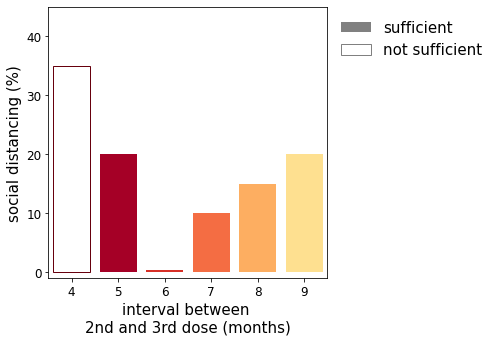

In [32]:
             
    
for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84']:

        for classi in ['adu']: 
    
            plt.subplots(figsize=(5,5))
    
            size = 200
        
            #plt.bar(-10, 10, color='grey', label = 'manageable \npeak')
            #plt.scatter([], [], linewidth = 2, edgecolor='grey', s= size, facecolor= 'white', label = 'lowest \npeak')
            
            plt.bar(-10, 10, color='grey', label = 'sufficient')
            plt.bar(-10, 10, edgecolor='grey',
                        facecolor= 'white', label = 'not sufficient')
            
            plt.legend(frameon=False, fontsize=15, loc='upper left', bbox_to_anchor = (1,1))

            for delay in [4,5,6,7,8,9]:
                
                if delay in [4,5]:
                    weeks = [60]
                else:
                    weeks = [53]
                
                for starting_week_SD in weeks:
                    
                    tag_scenario = 'delay_{}m_{}'.format(delay, classi)

                    tag_result = 'scenario_booster_delay_{}m_{}_{}{}_start-week{}'.format(delay, classi, ritmo, buffer, starting_week_SD)
                    
                    sufficient_reduction = dict_suf_red[tag_result]
                    optimal_reduction = dict_opt_red[tag_result]
                    
                    if sufficient_reduction != None:
                        if sufficient_reduction==0.:
                            plt.bar(delay, sufficient_reduction+0.005, color=cols_dict[tag_scenario])
                        elif sufficient_reduction > 0.:
                            plt.bar(delay, sufficient_reduction, color=cols_dict[tag_scenario])
                        else:
                            sys.exit()
                    else:
                        #plt.scatter(delay, 0.0, marker = 'x', s = 100, color=cols_dict[tag_scenario])
                        plt.bar(delay, optimal_reduction, edgecolor=cols_dict[tag_scenario], facecolor='white')

                    #plt.scatter(delay, optimal_reduction, s = size, facecolor='white', 
                    #            edgecolor=cols_dict[tag_scenario], linewidth = 2, zorder = 10)

            plt.xticks(np.arange(4,10), labels = ['4', '5', '6', '7', '8', '9'], fontsize=12)
            plt.yticks(np.arange(0,0.55, 0.1), 
                       labels = [int(a) for a in np.arange(0,0.55, 0.1)*100], fontsize=12)
            plt.xlabel('interval between \n2nd and 3rd dose (months)', fontsize=15)
            plt.ylabel('social distancing (%)', fontsize=15)
            
            plt.xlim([3.5, 9.5])
            plt.ylim([-0.01,0.45])
            
            plt.savefig('{}/6e_suffient-SD_barplot_{}_{}{}_{}_nruns{}_moving_threshold{}_voidbar_v2.png'.format(path_figure,
                                                                        ritmo,classi,buffer, 
                                                                        'application-SD', n_runs, int(threshold)),
                                                                        dpi = 200, bbox_inches = 'tight')
            plt.show()

# triggers for social distancing

## dictionary of triggers

In [33]:
trigger = {4: {4000: 7, 6000: 7, 8000: 8, 10000: 8, 12000: 8},
             5: {4000: 4, 6000: 6, 8000: 6, 10000: 7, 12000: 8},
             6: {4000: -3, 6000: 0, 8000: 2, 10000: 3, 12000: 4},
             7: {4000: -3, 6000: -2, 8000: 1, 10000: 2, 12000: 2},
             8: {4000: -3, 6000: -2, 8000: 0, 10000: 1, 12000: 2},
             9: {4000: -3, 6000: -2, 8000: 0, 10000: 1, 12000: 2}}

## peak vs SD given the same trigger

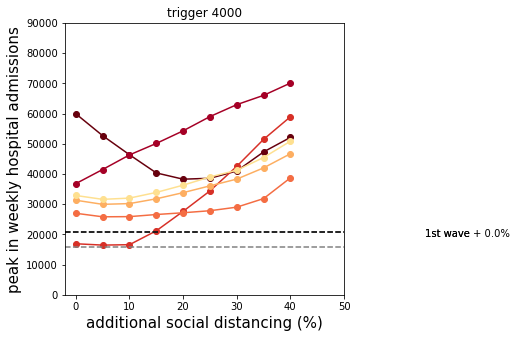

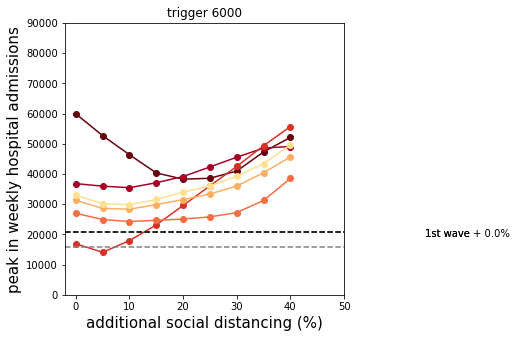

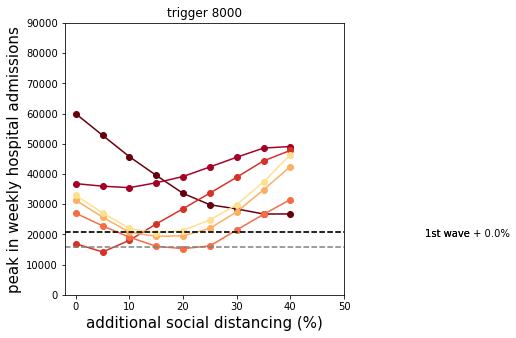

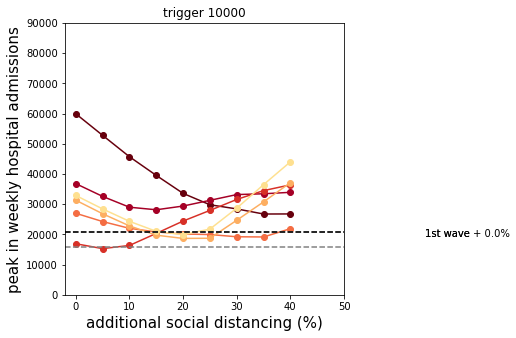

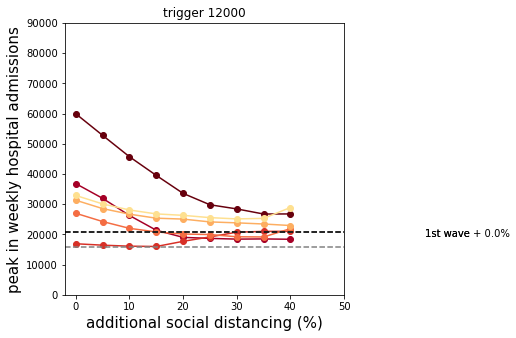

In [34]:
              
    
for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84']:
        
        i = 1.0

        for classi in ['adu']: 

            size = 50
            
            for soglia in [4000, 6000, 8000, 10000, 12000]:
                
                plt.subplots(figsize=(5,5))

                for delay in [4,5,6,7,8,9]:

                    weeks = [trigger[delay][soglia]+52]

                    for starting_week_SD in weeks:

                        i+=0.5

                        sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                        tag_scenario = 'delay_{}m_{}'.format(delay, classi)

                        n_runs = 100

                        build_ww = []
                        build_pp = []
                        reds = []

                        if delay in [4,5,6,7,8,9]:
                            list_reduction = np.arange(0., 0.45, 0.05)
                        else:
                            sys.exit()

                        for reduction in list_reduction: 

                            reduction = np.around(reduction,2)

                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)

                            if reduction == 0.:
                                tag = 'reduction{}_start-week53_4weeks'.format(reduction)
                        
                            my_file = main_folder+sub_folder+\
                                             '/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                        n_runs, tag)

                            if Path(my_file).exists():
                                
                                df = pd.read_csv(my_file)
                                
                                df = aggregate_moving_week(df)

                                ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52

                                pp = df.iloc[df['median'].idxmax()]['median']

                                build_ww.append(ww)
                                build_pp.append(pp)
                                reds.append(reduction)
                            else:
                                print('missing ', my_file)

                        alpha = 1.
                        line = '-o'

                        plt.plot(reds, build_pp, line, color=cols_dict[tag_scenario], alpha = alpha)

                #plt.xlabel('week of peak', fontsize=15)
                plt.ylabel('peak in weekly hospital admissions', fontsize=15)

                plt.axhline(peak['wave1'], linestyle='--', color='grey')
                #plt.axhline(peak['wave2'], linestyle='--', color='grey')
                #plt.axhline(peak['wave3'], linestyle='--', color='grey')
                plt.axhline(peak['wave5'], linestyle='--', color='grey')
                plt.axhline(threshold, linestyle='--', color='black')
                

                plt.text(0.65, peak['wave1']-1500, '1st wave')
                #plt.text(0.8, peak['wave2']-1500, '2nd wave')
                #plt.text(0.8, peak['wave3']-1500, '3rd wave')
                #plt.text(0.65, peak['wave5']-1500, 'Omicron wave')
                plt.text(0.65, threshold-1500, '1st wave + {}%'.format(100*threshold/peak['wave1']-100))
                
                plt.ylim([0,90000])
                
                plt.title('trigger ' + str(soglia))

                plt.xticks(np.arange(0., 0.6, 0.1), labels = [int(a) for a in np.arange(0., 0.6, 0.1)*100])

                plt.xlabel('additional social distancing (%)', fontsize=15)

                #plt.savefig('{}/9a_peak-vs-SD_soglia{}_{}_{}{}_{}_nruns{}_moving_threhsold{}.png'.format(path_figure,soglia,
                #                                                            ritmo,classi,buffer, 
                #                                                            'application-SD', n_runs, int(threshold)),
                #                                                            dpi = 200, bbox_inches = 'tight')

                plt.show()

## compute sufficient SD

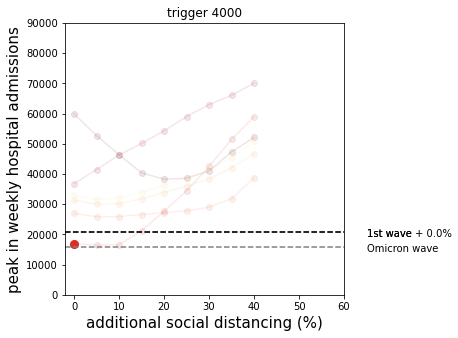

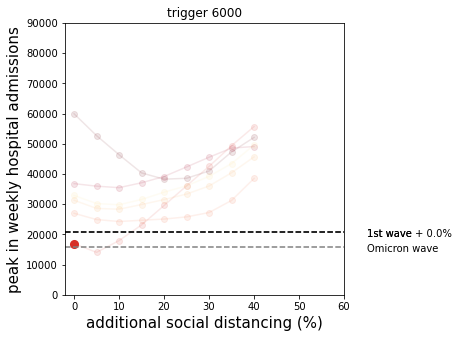

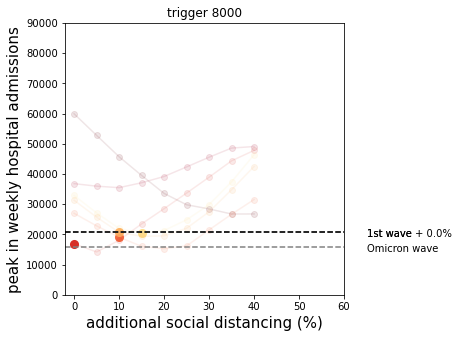

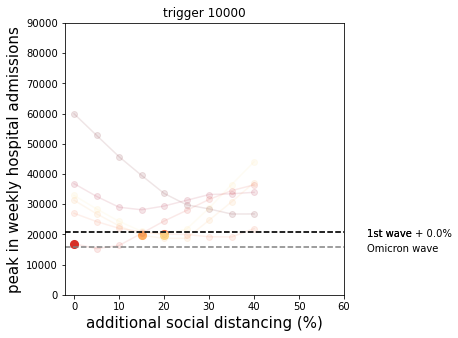

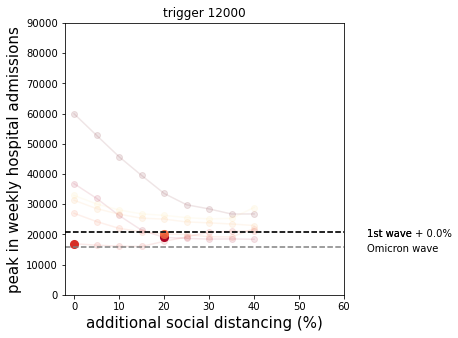

In [35]:
            
    
for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84']:
        
        i = 1.0

        for classi in ['adu']: 

            size = 50
            
            for soglia in [4000, 6000, 8000, 10000, 12000]:
                
                plt.subplots(figsize=(5,5))

                for delay in [4,5,6,7,8,9]:
                    
                    found = False

                    weeks = [trigger[delay][soglia]+52]

                    for starting_week_SD in weeks:

                        i+=0.5

                        sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                        tag_scenario = 'delay_{}m_{}'.format(delay, classi)

                        n_runs = 100

                        build_ww = []
                        build_pp = []
                        reds = []

                        if delay in [4,5,6,7,8,9]:
                            list_reduction = np.arange(0., 0.45, 0.05)
                        else:
                            sys.exit()

                        for reduction in list_reduction: 

                            reduction = np.around(reduction,2)

                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)

                            if reduction == 0.:
                                tag = 'reduction{}_start-week53_4weeks'.format(reduction)
                        
                            my_file = main_folder+sub_folder+\
                                             '/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                        n_runs, tag)

                            if Path(my_file).exists():
                                
                                df = pd.read_csv(my_file)
                                #df = aggregate_week(df)
                                
                                df = aggregate_moving_week(df)
                                

                                ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52

                                pp = df.iloc[df['median'].idxmax()]['median']

                                build_ww.append(ww)
                                build_pp.append(pp)
                                reds.append(reduction)
                            else:
                                print('missing ', my_file[-90:])
                                
                            current_size = 50

                            if pp < threshold and not found:

                                plt.scatter(reduction, pp, 
                                            edgecolor=cols_dict[tag_scenario], 
                                            linewidth=2,
                                            facecolor=cols_dict[tag_scenario], 
                                            marker = mm[ritmo], s = current_size, label=etichetta_ritardo[ritmo][delay]+\
                                            ' ({})'.format(classi))

                                found = True

                        alpha = 0.1
                        line = '-o'

                        plt.plot(reds, build_pp, line, color=cols_dict[tag_scenario], alpha = alpha)

                #plt.xlabel('week of peak', fontsize=15)
                plt.ylabel('peak in weekly hospital admissions', fontsize=15)

                plt.axhline(peak['wave1'], linestyle='--', color='grey')
                plt.axhline(peak['wave5'], linestyle='--', color='grey')
                plt.axhline(threshold, linestyle='--', color='black')


                plt.text(0.65, peak['wave1']-1500, '1st wave')
                plt.text(0.65, peak['wave5']-1500, 'Omicron wave')
                plt.text(0.65, threshold-1500, '1st wave + {}%'.format(100*threshold/peak['wave1']-100))

                plt.ylim([0,90000])
                
                plt.title('trigger ' + str(soglia))

                plt.xticks(np.arange(0., 0.65, 0.1), labels = [int(a) for a in np.arange(0., 0.65, 0.1)*100])

                plt.xlabel('additional social distancing (%)', fontsize=15)

                #plt.savefig('{}/9b_peak-vs-SD_soglia{}_{}_{}{}_{}_nruns{}_shaded_moving_threhsold{}.png'.format(path_figure,
                #                                                            soglia,
                #                                                            ritmo,classi,buffer, 
                #                                                            'application-SD', n_runs, int(threshold)),
                #                                                            dpi = 200, bbox_inches = 'tight')

                plt.show()

## plot SD vs H inci

In [36]:
trigger

{4: {4000: 7, 6000: 7, 8000: 8, 10000: 8, 12000: 8},
 5: {4000: 4, 6000: 6, 8000: 6, 10000: 7, 12000: 8},
 6: {4000: -3, 6000: 0, 8000: 2, 10000: 3, 12000: 4},
 7: {4000: -3, 6000: -2, 8000: 1, 10000: 2, 12000: 2},
 8: {4000: -3, 6000: -2, 8000: 0, 10000: 1, 12000: 2},
 9: {4000: -3, 6000: -2, 8000: 0, 10000: 1, 12000: 2}}

In [37]:
 

save_res = pd.DataFrame(columns=['scenario','panel','SD','hosp'])

for panel in ['sufficient','most effective']:
    
    for ritmo in ['ritmo2_start20210901']:

        for buffer in ['_buffer30days_cov70-84']:

            for classi in ['adu']: 

                for delay in [4,5,6,7,8,9]:

                    weeks = np.unique(np.array(list(trigger[delay].values())))+52

                    for starting_week_SD in weeks:

                        found = False

                        sufficient_reduction = -0.01

                        sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                        tag_scenario = 'delay_{}m_{}'.format(delay, classi)

                        n_runs = 100

                        build_ww = []
                        build_pp = []
                        reds = []

                        list_reduction = np.arange(0., 0.45, 0.05)

                        for reduction in list_reduction: 

                            reduction = np.around(reduction,2)

                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)

                            if reduction == 0.:
                                tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                            my_file = main_folder+sub_folder+\
                                             '/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                        n_runs, tag)

                            if Path(my_file).exists():

                                df = pd.read_csv(my_file)
                                
                                df = aggregate_moving_week(df)

                                if starting_week_SD-1 > 52:
                                    gg = datetime.date.fromisocalendar(2022, starting_week_SD-52-1, 7).strftime('%Y-%m-%d')
                                else:
                                    gg = datetime.date.fromisocalendar(2021, starting_week_SD-1, 7).strftime('%Y-%m-%d')                  

                                ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52

                                pp = df.iloc[df['median'].idxmax()]['median']

                                start_inci = df[df['abs_week']==starting_week_SD+53-1]['median'].iloc[0]

                                build_ww.append(ww)
                                build_pp.append(pp)
                                reds.append(reduction)

                                if pp < threshold and not found:

                                    sufficient_reduction = reduction

                                    found = True 
                            else:
                                print('missing ', my_file[-90:])
                            
                        if panel == 'sufficient':
                            if sufficient_reduction < 0:
                                continue
                            else:
                                save_res = save_res._append({'scenario': tag_scenario, 
                                        'panel': panel, 
                                        'SD': sufficient_reduction, 
                                        'hosp': start_inci, 
                                        'week_start_SD': starting_week_SD}, ignore_index=True)
                            
                        elif panel == 'most effective':
                            optimal_reduction = list_reduction[np.array(build_pp).argmin()]
                            save_res = save_res._append({'scenario': tag_scenario, 
                                        'panel': panel, 
                                        'SD': optimal_reduction, 
                                        'hosp': start_inci, 
                                        'week_start_SD': starting_week_SD}, ignore_index=True)
                        else:
                            sys.exit()

## dictionary save_res

In [38]:
save_res

,scenario,panel,SD,hosp,week_start_SD
0,delay_5m_adu,sufficient,0.20,15477.0,60.0
1,delay_6m_adu,sufficient,0.00,4831.0,49.0
2,delay_6m_adu,sufficient,0.00,6080.5,52.0
3,delay_6m_adu,sufficient,0.00,9361.0,54.0
4,delay_6m_adu,sufficient,0.00,11582.0,55.0
5,delay_6m_adu,sufficient,0.00,14354.5,56.0
6,delay_7m_adu,sufficient,0.10,9584.0,53.0
7,delay_7m_adu,sufficient,0.20,14347.5,54.0
8,delay_8m_adu,sufficient,0.10,8202.0,52.0
9,delay_8m_adu,sufficient,0.15,10724.0,53.0


In [39]:
save_res[save_res['scenario']=='delay_4m_adu']

,scenario,panel,SD,hosp,week_start_SD
12,delay_4m_adu,most effective,0.20,7310.5,59.0
13,delay_4m_adu,most effective,0.35,15164.5,60.0


# without BA2

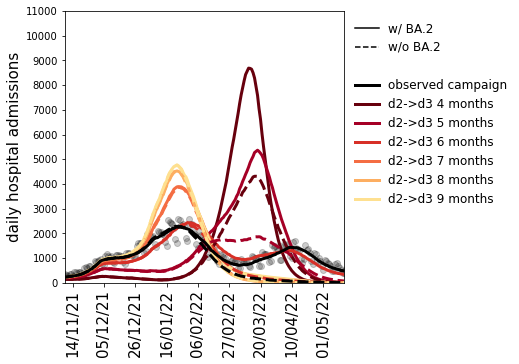

In [43]:
## comparison

H_adm_cut = H_adm[H_adm['date']>='2021-07-25'].reset_index(drop=True)



for classi in ['adu']: 
    
    plt.subplots(figsize=(5,5))
    
    plt.plot([],[], color='black', linestyle = '-', label = 'w/ BA.2')
    plt.plot([],[], color='black', linestyle = '--', label = 'w/o BA.2')
    plt.plot([],[], color='white', linestyle = '--', label = ' ')
    
    
    #plt.plot(baseline.index, baseline['median'], color='black', label='fit', linewidth = 3)
    #plt.fill_between(baseline.index, baseline['p1'].values, 
      #                               baseline['p2'].values, color='chocolate', alpha=0.3)
        
    sub_folder = 'scenario_booster_delay_7m_adu_ritmo3_woBA2/'
    
    baseline_woBA2 = pd.read_csv(main_folder+sub_folder+'new_H_France_scenario_fit_runs{}_both_both_reduction0.0_start-week53_4weeks.csv'.format(
                                                                                                    n_runs))
        
    plt.plot(baseline['median'], label='observed campaign', 
                linewidth = 3, color='black', linestyle='-', zorder = 10)
    plt.plot(baseline_woBA2['median'], 
                linewidth = 3, color='black', linestyle='--', zorder = 10)
                
    linestyles = ['-', '--', ':', '-.']
    
    h=-1
            
    for ritmo in ['ritmo2_start20210901']:
    
        for buffer in ['_buffer30days_cov70-84', '_buffer30days_cov70-84_woBA2']:
            
            h+=1

            for delay in [4,5,6,7,8,9]:

                sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                tag_scenario = 'delay_{}m_{}'.format(delay, classi)

                i = 0

                n_runs = 100

                for reduction in [0.]: 

                    reduction = np.around(reduction,2)
                    
                    tag = 'reduction{}_start-week53_4weeks'.format(reduction)
                    
                    if delay in [4,5] and buffer == '_buffer30days_cov70-84_woBA2':
                        tag = 'reduction{}_start-week60_4weeks'.format(reduction)

                    df = pd.read_csv(main_folder+sub_folder+'/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                n_runs, tag))
                    #df = df[df['time']>=wild_origin].reset_index(drop=True)

                    plt.plot(df['median'], 
                             label=etichetta_ritardo[ritmo][delay], # ' ({} {})'.format(classi,buffer[13:]), 
                             linewidth = 3, color=cols_dict[tag_scenario], linestyle=linestyles[h])

                    if buffer == '_buffer30days_cov70-84':
        
                        plt.legend(frameon = False, loc='upper left', bbox_to_anchor=(1,1), 
                                       fontsize=12)

                    i+=1
                    
    plt.ylabel('daily hospital admissions', fontsize=15)

    plt.xlim([8,len(df)])
    plt.yticks(np.arange(0,12000,1000))
    plt.ylim([0, 11000])

   # plt.title(ritmo + ', reduction 0%'+'\n'+buffer)

    move = 7
    end = len(df)
    step = 21
    dates=pd.to_datetime(df['time']).apply(lambda x:x.strftime("%d/%m/%y"))
    plt.xticks(np.arange(move,end,step), labels = dates[move: end : step],
               rotation=90, fontsize=15) 

    plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'], 
                color='black', alpha = 0.2, label = 'data')
    
    plt.xlim([baseline[baseline['time']=='2021-11-09'].index[0], len(baseline)-8])

    #plt.axvline(x = baseline[baseline['time']=='2022-01-03'].index[0], 
    #            color='tab:red', linestyle = '--')


    #plt.axvline(x = baseline[baseline['time']=='2022-01-03'].index[0]+4)

    #plt.yscale('log')
    #plt.ylim([10,100000])
    plt.savefig('{}/2c_traj_{}_red_{}_nruns{}_woBA2.png'.format(path_figure, classi,reduction,n_runs),
                                                               dpi = 200, bbox_inches = 'tight')

    plt.show()

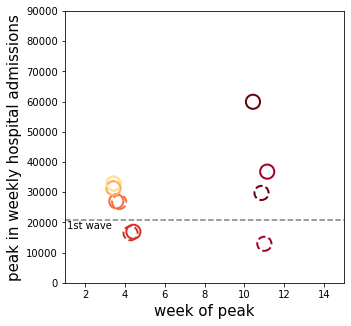

In [44]:
plt.subplots(figsize=(5,5))
    
for buffer in ['_buffer30days_cov70-84', '_buffer30days_cov70-84_woBA2']:

    for ritmo in ['ritmo2_start20210901']:

        size = 200

        df = H_adm_week.copy()

        ww = df.iloc[df['hosp_pred'].idxmax()]['abs_week']-53-52

        pp = df.iloc[df['hosp_pred'].idxmax()]['hosp_pred']

        """
        plt.scatter(ww, pp, 
                    edgecolor='black', 
                    linewidth=2,
                    facecolor='black', 
                    marker = 'o', s = size, label = 'data')
        """

        df = baseline_week.copy()

        ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52

        pp = df.iloc[df['median'].idxmax()]['median']

        #plt.scatter(ww, pp, 
        #            edgecolor='black', 
        #            linewidth=2,
        #            facecolor='white', 
        #            marker = 'o', s = size, label = 'model fit')

        for classi in ['adu']: 

            for delay in [4,5,6,7,8,9]:

                sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                tag_scenario = 'delay_{}m_{}'.format(delay, classi)

                n_runs = 100

                for reduction in [0.]: 

                    reduction = np.around(reduction,2)

                    tag = 'reduction{}_start-week53_4weeks'.format(reduction)
                    if delay in [4,5] and buffer == '_buffer30days_cov70-84_woBA2':
                        tag = 'reduction{}_start-week60_4weeks'.format(reduction)

                    df = pd.read_csv(main_folder+sub_folder+\
                                     '/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                n_runs, tag))
                    #df = aggregate_week(df)
                    df = aggregate_moving_week(df)
                    

                    ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52
                    #print(ww)

                    pp = df.iloc[df['median'].idxmax()]['median']
                    
                    if 'cov70-84' in buffer:
                        face_col = 'None'
                        edge_col =  cols_dict[tag_scenario]
                    else:
                        face_col=cols_dict[tag_scenario]
                        edge_col = 'white'
                        
                    if 'BA2' in buffer:
                        line='--'
                    else:
                        line = '-'
                        

                    plt.scatter(ww, pp, 
                                edgecolor=edge_col, 
                                linewidth=2,
                                facecolor=face_col, 
                                marker = mm[ritmo], s = size, linestyle = line, 
                                label=etichetta_ritardo[ritmo][delay]+\
                                ' ({})'.format(classi))

plt.xlabel('week of peak', fontsize=15)
plt.ylabel('peak in weekly hospital admissions', fontsize=15)

plt.axhline(peak['wave1'], linestyle='--', color='grey')
#plt.axhline(peak['wave2'], linestyle='--', color='grey')
#plt.axhline(peak['wave3'], linestyle='--', color='grey')

plt.text(1.1, peak['wave1']-2800, '1st wave')
#plt.text(1.1, peak['wave2']-1500, '2nd wave')
#plt.text(1.1, peak['wave3']-1500, '3rd wave')

#plt.legend(frameon=False, bbox_to_anchor=(1,1), fontsize=11)

plt.xlim([1,15])
plt.ylim([0,90000])

plt.savefig('{}/3_peak-vs-peaktime_red{}_nruns{}_woBA2_moving.png'.format(path_figure, reduction,n_runs),
                                                                    dpi = 200, bbox_inches = 'tight')

plt.show()

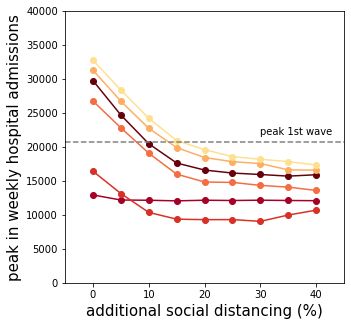

In [45]:
            
    
for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84_woBA2']:

        for classi in ['adu']: 
            
            i = 1.0
    
            plt.subplots(figsize=(5,5))

            size = 50

            for delay in [4,5,6,7,8,9]:
                
                if delay in [4,5]:
                    weeks = [60]
                else:
                    weeks = [53]
                
                for starting_week_SD in weeks:
                
                    i+=0.5

                    sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                    tag_scenario = 'delay_{}m_{}'.format(delay, classi)

                    n_runs = 100

                    build_ww = []
                    build_pp = []

                    if delay in [4,5,6,7,8,9]:
                        list_reduction = np.arange(0., 0.45, 0.05)
                    elif delay == 6:
                        list_reduction = np.arange(0., 0.45, 0.05)
                    else:
                        sys.exit()

                    for reduction in list_reduction: 

                        reduction = np.around(reduction,2)

                        if delay in [4,5]:
                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)
                        else:
                            tag = 'reduction{}_start-week{}_4weeks'.format(reduction, starting_week_SD)

                        if reduction == 0.:
                            tag = 'reduction{}_start-week53_4weeks'.format(reduction)
                            
                            if delay in [4,5] and buffer == '_buffer30days_cov70-84_woBA2':
                                tag = 'reduction{}_start-week60_4weeks'.format(reduction)

                        df = pd.read_csv(main_folder+sub_folder+\
                                         '/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                    n_runs, tag))
                        #df = aggregate_week(df)
                        df = aggregate_moving_week(df)
                        
                        ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52

                        pp = df.iloc[df['median'].idxmax()]['median']

                        build_ww.append(ww)
                        build_pp.append(pp)

                        if reduction == 0.:
                            current_size = size
                        else:
                            current_size = size*(1.-1*reduction)
                            #current_size = 0
                        
                    alpha = 1.0
                    line = '-o'                   
                    plt.plot(list_reduction, build_pp, line, color=cols_dict[tag_scenario], alpha = alpha)

            #plt.xlabel('week of peak', fontsize=15)
            plt.ylabel('peak in weekly hospital admissions', fontsize=15)

            plt.axhline(peak['wave1'], linestyle='--', color='grey')
            #plt.axhline(peak['wave2'], linestyle='--', color='grey')
            #plt.axhline(peak['wave3'], linestyle='--', color='grey')
            #plt.axhline(peak['wave5'], linestyle='--', color='grey')

            plt.text(0.30, peak['wave1']+1000, 'peak 1st wave')
            #plt.text(0.8, peak['wave2']-1500, '2nd wave')
            #plt.text(0.8, peak['wave3']-1500, '3rd wave')
            #plt.text(0.65, peak['wave5']-1500, 'Omicron wave')

            plt.ylim([0,40000])

            plt.xticks(np.arange(0., 0.45, 0.1), labels = [int(a) for a in np.arange(0., 0.45, 0.1)*100])
            plt.xlim([-0.05, 0.45])

            plt.xlabel('additional social distancing (%)', fontsize=15)

            plt.savefig('{}/6h_peak-vs-SD_{}_{}{}_{}_nruns{}_woBA2_moving.png'.format(path_figure, ritmo,classi,buffer, 
                                                                        'application-SD', n_runs),
                                                                        dpi = 200, bbox_inches = 'tight')

            plt.show()

# accelerate booster campaign

In [46]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## fig 5

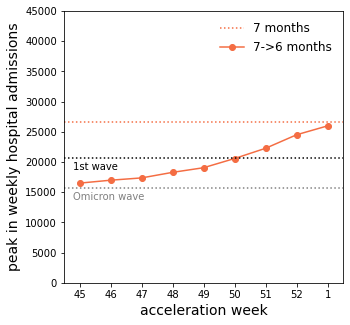

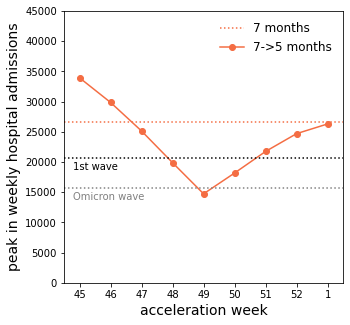

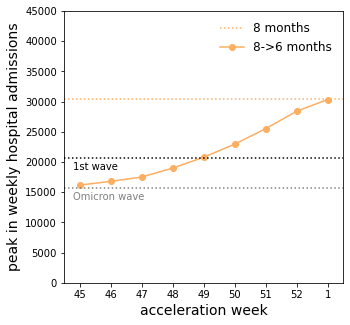

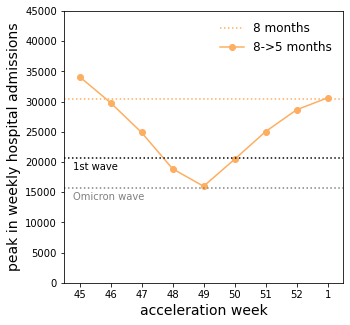

In [47]:

    
for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days']:
        
        for cov in ['_cov70-84']:

            for classi in ['adu']: 
                
                for delay in [7,8]:
                    
                    shorten_dict = {6: ['shorten1m'], 
                                    7: ['shorten1m','shorten2m'],
                                    8: ['shorten2m','shorten3m']}
                 
                    for shorten in shorten_dict[delay]:
                        
                        fig, ax = plt.subplots(figsize=(5,5))
                        
                        for acceleration in ['']:

                            sub_folder = 'scenario_booster_delay_{}m_{}_{}{}{}{}/'.format(delay, classi, ritmo, buffer, 
                                                                                        acceleration, 
                                                                                        cov)
                            tag_scenario = 'delay_{}m_{}'.format(delay, classi)

                            n_runs = 100

                            for reduction in [0.]: 

                                reduction = np.around(reduction,2)

                                tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                                df = pd.read_csv(main_folder+sub_folder+'/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                            n_runs, tag))
                                #df = df[df['time']>=wild_origin].reset_index(drop=True)

                                df = aggregate_week(df)

                                pp = df.iloc[df['median'].idxmax()]['median']

                                plt.axhline(pp, color=cols_dict[tag_scenario], linestyle = ':', label = '{} months'.format(delay))

                        alpha = 1
                        
                        if delay == 8 and shorten == 'shorten3m':
                            alpha = 1
                        elif delay == 7 and shorten == 'shorten2m':
                            alpha = 1
                        else: 
                            alpha = 1
                        
                        pp_list = []
                        ww = []

                        for week_accel in np.arange(45,54):
                            
                            acceleration = '_accel_w{}_{}_buf60d'.format(week_accel, shorten)

                            sub_folder = 'scenario_booster_delay_{}m_{}_{}{}{}{}/'.format(delay, classi, 
                                                                                          ritmo, buffer, 
                                                                                          acceleration, 
                                                                                          cov)

                            tag_scenario = 'delay_{}m_{}'.format(delay, classi)

                            n_runs = 100

                            for reduction in [0.]: 

                                reduction = np.around(reduction,2)

                                tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                                df = pd.read_csv(main_folder+sub_folder+'/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                            n_runs, tag))
                                #df = df[df['time']>=wild_origin].reset_index(drop=True)

                                df = aggregate_moving_week(df)

                                pp = df.iloc[df['median'].idxmax()]['median']

                                ww.append(week_accel)
                                pp_list.append(pp)
                                
                        plt.plot(ww, pp_list, '-o', color=cols_dict[tag_scenario], alpha = alpha,
                                label='{}->{} months'.format(delay, delay - int(shorten[7])))  

                        plt.legend(frameon = False, loc='upper right', 
                                   fontsize=12)
                        plt.ylabel('peak in weekly hospital admissions', fontsize=14)
                        
                        plt.axhline(peak['wave5'], linestyle=':', color='grey')
                        plt.axhline(threshold, linestyle=':', color='black')
                        plt.text(44.8, peak['wave5']-2000, 'Omicron wave', color='grey')
                        if threshold != peak['wave1']:
                            plt.text(44.8, threshold-2000, '1st wave + {}%'.format(int(100*threshold/peak['wave1']-100)))
                        else:
                            plt.text(44.8, threshold-2000, '1st wave')


                        plt.yticks(np.arange(0,51000,5000))
                        plt.ylim([0, 45000])

                        ax.set_xticks([45,46,47,48,49,50,51,52,53])
                        ax.set_xticklabels([45,46,47,48,49,50,51,52,1])
                        ax.set_xlim([44.5, 53.5])

                        #ax.set_xlabel('week reducing delay \n or implementing SD')
                        ax.set_xlabel('acceleration week', fontsize = 14)

                        plt.savefig('{}/11g_shorten_{}m_accelonly_accel{}_threshold{}_shorten{}.png'.format(path_figure, 
                                                                                    delay, acceleration[-5:], threshold,
                                                                                    shorten),
                                                                                    dpi = 200, bbox_inches = 'tight')

                        plt.show()

# impact of duration of SD

## optimal/sufficient SD vs duration of SD

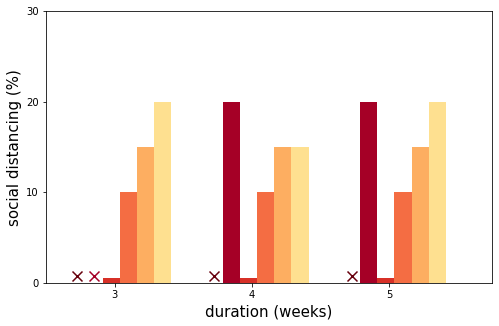

In [48]:
             
    
for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84']:

        for classi in ['adu']: 
    
            plt.subplots(figsize=(8,5))
            
            plt.scatter([], [], color = 'white', label = ' ')
            
            plt.bar(-10, 0, color='grey', label = 'sufficient')
            plt.scatter([], [], linewidth = 2, edgecolor='grey', s= size, facecolor= 'white', label = 'most effective')

            #plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1),
            #          fontsize=20)
        
            
            i = -800/2000.

            for delay in [4,5,6,7,8,9]:
                i +=250/2000.
                
                trigger_value = 10000
                
                for durata in [3,4,5]:
                    
                    #starting_week_SD = trigger[delay][trigger_value]+52
                    starting_week_SD = 52+1
                    
                    if delay in [4,5]:
                        starting_week_SD = 52+8
                    
                    found = False
                    
                    sufficient_reduction = -0.01

                    sub_folder = 'scenario_booster_delay_{}m_{}_{}{}/'.format(delay, classi, ritmo, buffer)

                    tag_scenario = 'delay_{}m_{}'.format(delay, classi)

                    n_runs = 100

                    build_ww = []
                    build_pp = []
                    reds = []

                    list_reduction = np.arange(0., 0.45, 0.05)

                    for reduction in list_reduction: 

                        reduction = np.around(reduction,2)

                        tag = 'reduction{}_start-week{}_{}weeks'.format(reduction, starting_week_SD, durata)

                        if reduction == 0.:
                            tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                        my_file = main_folder+sub_folder+\
                                         '/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                    n_runs, tag)

                        if Path(my_file).exists():

                            df = pd.read_csv(my_file)

                            if starting_week_SD-1 > 52:
                                gg = datetime.date.fromisocalendar(2022, starting_week_SD-52-1, 7).strftime('%Y-%m-%d')
                            else:
                                gg = datetime.date.fromisocalendar(2021, starting_week_SD-1, 7).strftime('%Y-%m-%d')                  

                            df = aggregate_week(df)

                            ww = df.iloc[df['median'].idxmax()]['abs_week']-53-52

                            pp = df.iloc[df['median'].idxmax()]['median']

                            start_inci = df[df['abs_week']==starting_week_SD+53-1]['median'].iloc[0]

                            build_ww.append(ww)
                            build_pp.append(pp)
                            reds.append(reduction)

                            if pp < threshold and not found:

                                sufficient_reduction = reduction

                                found = True 
                          
                        else:
                            print('missing ', my_file[-90:])
                        
                        
                    if sufficient_reduction >= 0:
                       # plt.scatter(trigger_value+i, sufficient_reduction, marker='o', s=size,
                       #             color=cols_dict[tag_scenario])
                        plt.bar(durata+i, sufficient_reduction, width = 250/2000., 
                                   color=cols_dict[tag_scenario])
                    if sufficient_reduction == 0:
                        plt.bar(durata+i, 0.005, width = 250/2000., 
                                   color=cols_dict[tag_scenario])
                    if sufficient_reduction <0:
                        plt.scatter(durata+i, 0.007, marker = 'x', s = 100., 
                                   color=cols_dict[tag_scenario])                        
                        
                    #optimal_reduction = list_reduction[np.array(build_pp).argmin()]
                    #plt.scatter(durata+i, optimal_reduction, marker='o', s=100,
                    #                edgecolor=cols_dict[tag_scenario], facecolor='None', linewidth=3)
                        
                        
            #plt.axhline(y=0.5, color='black', linestyle = '--')

            plt.xlabel('duration (weeks)', fontsize=15)
            plt.yticks(np.arange(0,0.55, 0.1), labels = [int(a) for a in np.arange(0,0.55, 0.1)*100])
            
            #plt.xticks([4100, 6000, 8000, 10000, 12000])
            #plt.xlim([3000, 13000])
            
            plt.xlim([2.5, 5.75])
            plt.ylim([0,0.3])
            
            plt.xticks(np.arange(3,6))
            
            plt.ylabel('social distancing (%)', fontsize=15)
            
            plt.savefig('{}/13a_suffient-SD_vs_inci-trigger_{}_{}{}_{}_nruns{}_withR_factor{}_{}runs_noptimal_threshold{}_sufficient_only.png'.format(path_figure, ritmo,classi,buffer, 
                                                                        'application-SD', n_runs, threshold/peak['wave1'], n_runs, int(threshold)),
                                                                        dpi = 200, bbox_inches = 'tight')
            plt.show()

# sensitivity

## no waning in immunity

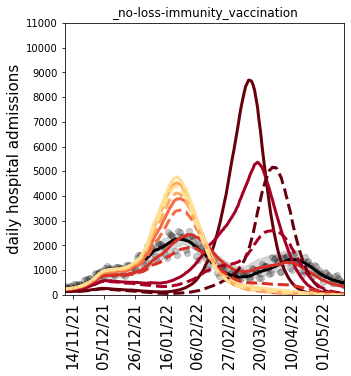

In [49]:

    
for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84']:
    
        plt.subplots(figsize=(5,5))  
        plt.plot(baseline.index.to_numpy(), baseline['median'].to_numpy(), color='black', label='fit', linewidth = 3)
        plt.fill_between(baseline.index.to_numpy(), baseline['p1'].values, baseline['p2'].values, color='grey', alpha=0.3)

        for tag_analysis in ['', '_no-loss-immunity_vaccination']:
                    
            for classi in ['adu']: 

                for delay in [4,5,6,7,8,9]:
                    sub_folder = 'scenario_booster_delay_{}m_{}_{}{}{}/'.format(delay, classi, 
                                                                                ritmo, buffer, tag_analysis)
                    tag_scenario = 'delay_{}m_{}'.format(delay, classi)
                    i = 0
                    n_runs = 100

                    for reduction in [0.]: 
                        reduction = np.around(reduction,2)
                        tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                        my_file = main_folder+sub_folder+'/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                    n_runs, tag)

                        if Path(my_file).exists():

                            df = pd.read_csv(my_file)
                            
                            if tag_analysis == '':
                                plt.plot(df['median'], label=etichetta_ritardo[ritmo][delay]+ ' ({})'.format(classi), 
                                    linewidth = 3, color=cols_dict[tag_scenario])
                            else:
                                plt.plot(df['median'], label=etichetta_ritardo[ritmo][delay]+ ' ({})'.format(classi), 
                                    linewidth = 3, linestyle = '--', color=cols_dict[tag_scenario])

                        else: 
                            print('missing')

                        i+=1

        #plt.legend(frameon = False, loc='upper left', bbox_to_anchor=(1,1), fontsize=12)
        plt.ylabel('daily hospital admissions', fontsize=15)
        plt.xlim([8,len(df)])
        plt.yticks(np.arange(0,12000,1000))
        plt.ylim([0, 11000])
        plt.title(ritmo + ', reduction 0%'+'\n'+buffer)
        move = 7
        end = len(df)
        step = 21
        dates=pd.to_datetime(df['time']).apply(lambda x:x.strftime("%d/%m/%y"))
        plt.xticks(np.arange(move,end,step), labels = dates[move: end : step],
                   rotation=90, fontsize=15) 
        plt.xlim([baseline[baseline['time']=='2021-11-09'].index[0], len(baseline)-8])
        plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'], 
                    color='black', alpha = 0.2, label = 'data')
        plt.title(tag_analysis)
        #plt.savefig('{}/14_traj_{}{}_red_{}_nruns{}{}.png'.format(path_figure,ritmo,buffer,reduction,n_runs,
        #                                                          tag_analysis),
        #                                                            dpi = 200, bbox_inches = 'tight')
        plt.show()

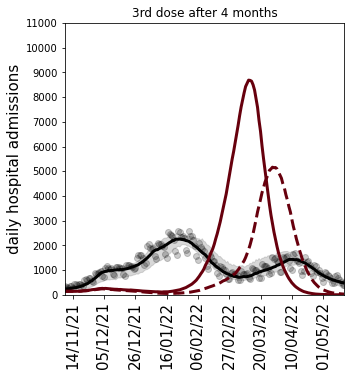

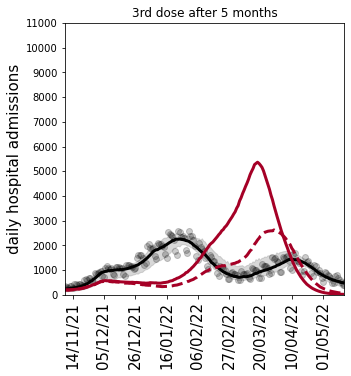

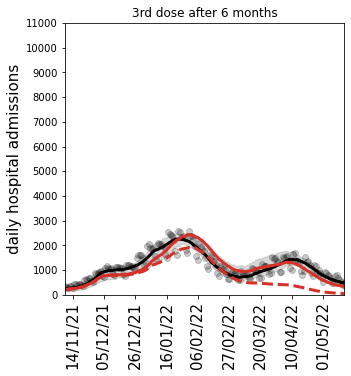

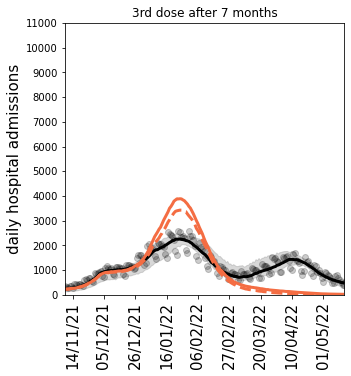

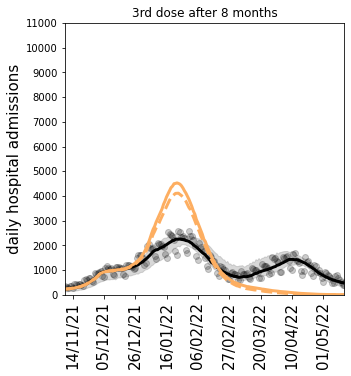

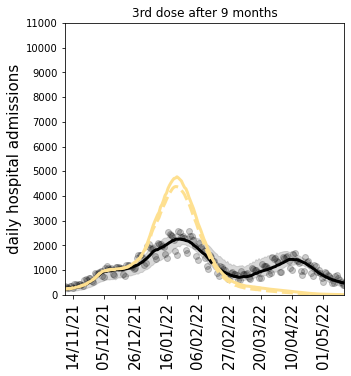

In [50]:

    
for ritmo in ['ritmo2_start20210901']:
    
    for buffer in ['_buffer30days_cov70-84']:
                    
        for classi in ['adu']: 

            for delay in [4,5,6,7,8,9]:
                    
                plt.subplots(figsize=(5,5))  
                plt.plot(baseline.index.to_numpy(), baseline['median'].to_numpy(), color='black', label='fit', linewidth = 3)
                plt.fill_between(baseline.index.to_numpy(), baseline['p1'].values, baseline['p2'].values, color='grey', alpha=0.3)

                for tag_analysis in ['', '_no-loss-immunity_vaccination']:
                    
                    sub_folder = 'scenario_booster_delay_{}m_{}_{}{}{}/'.format(delay, classi, 
                                                                                ritmo, buffer, tag_analysis)
                    tag_scenario = 'delay_{}m_{}'.format(delay, classi)
                    i = 0
                    n_runs = 100

                    for reduction in [0.]: 
                        reduction = np.around(reduction,2)
                        tag = 'reduction{}_start-week53_4weeks'.format(reduction)

                        my_file = main_folder+sub_folder+'/new_H_France_scenario_fit_runs{}_both_both_{}.csv'.format(
                                                                                                    n_runs, tag)

                        if Path(my_file).exists():

                            df = pd.read_csv(my_file)
                            
                            if tag_analysis == '':
                                plt.plot(df['median'], label=etichetta_ritardo[ritmo][delay]+ ' ({})'.format(classi), 
                                    linewidth = 3, color=cols_dict[tag_scenario])
                            else:
                                plt.plot(df['median'], label=etichetta_ritardo[ritmo][delay]+ ' ({})'.format(classi), 
                                    linewidth = 3, linestyle = '--', color=cols_dict[tag_scenario])

                        else: 
                            print('missing')

                        i+=1

                #plt.legend(frameon = False, loc='upper left', bbox_to_anchor=(1,1), fontsize=12)
                plt.ylabel('daily hospital admissions', fontsize=15)
                plt.xlim([8,len(df)])
                plt.yticks(np.arange(0,12000,1000))
                plt.ylim([0, 11000])
                plt.title(ritmo + ', reduction 0%'+'\n'+buffer)
                move = 7
                end = len(df)
                step = 21
                dates=pd.to_datetime(df['time']).apply(lambda x:x.strftime("%d/%m/%y"))
                plt.xticks(np.arange(move,end,step), labels = dates[move: end : step],
                           rotation=90, fontsize=15) 
                plt.xlim([baseline[baseline['time']=='2021-11-09'].index[0], len(baseline)-8])
                plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'], 
                            color='black', alpha = 0.2, label = 'data')
                plt.title(tag_analysis)
                plt.title('3rd dose after {} months'.format(delay))
                plt.savefig('{}/14_traj_{}{}_red_{}_nruns{}{}_interval{}.png'.format(path_figure,ritmo,buffer,reduction,n_runs,
                                                                          tag_analysis, delay),
                                                                            dpi = 200, bbox_inches = 'tight')
                plt.show()